In [2]:
import os, sys, shutil
sys.path.insert(0,"/home/hschia/data/love")
sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("plot_style.mplstyle")

from scipy import interpolate
from importlib import reload
import multiprocess, json
import time
import pickle
import pandas as pd
import glob
from pprint import pprint

# IAS GW pipeline
import template_bank_generator_love as tg
import template_bank_params_O3a_love as tbp
import params_love as params
import loveNum_waveform_merger as lovewf
import utils_love as utils

# Sklearn ML methods
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

# %matplotlib widget
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# %matplotlib widget
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)

In [3]:
# Functions that transform parameters
def eta(m1,m2):
    return m1*m2/(m1+m2)**2

def q_from_eta(eta):
    return (1-np.sqrt(1-4*eta)-2*eta)/(2*eta)

def mchirp(m1, m2):
    return (m1+m2)*eta(m1,m2)**0.6

def leff(m1, m2, l1, l2):
    return (16/13) * ((m1+12*m2)*m1**4 * l1 + (m2 + 12*m1)*m2**4 * l2) / (m1 + m2)**5

In [4]:
# Directories for storing data
DIR = '/home/hschia/data/love'
HIGHM_DIR = 'mchirp_gtr3_merger'
asd_file = os.path.join(DIR, HIGHM_DIR, 'ref_asd_o3a.npy')

# Masking hyperparameters for parameter space
M_min = 2 # Over estimate, mch_mask will remove most of low mass
M_max = 40

# fmin_cutoff Close to 2200/M_max (fISCO for BBH = 2200/M). At most 20Hz, which is Mtot ~ 100Msun. 
# For anything bigger than BH, they would merge before ISCO, so ours fmin_cutoff=60 
fmin_cutoff = 60 

mch_cutoff = 3
mch_cutoff_upper = 15
mch_cutoff_extend = 2
Mchmin, Mchmax = mch_cutoff, mch_cutoff_upper
eta_min=0.05

lovelog_min, lovelog_max = np.log10(500), 7
qmin = q_from_eta(eta_min)
qmin

0.05572809000084139

## 1. Load reference psd and generate frequency grid

### 1.1 Load template bank reference PSD

In [5]:
jay_asdfref = np.load(tbp.asd_filepath) # Jay's HM ref_asd
my_asdfref = np.load(asd_file)
freq, asd =  my_asdfref[0], my_asdfref[1]
f_axis = np.geomspace(15, 8e2, 1000)
my_asdf_interp = np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),
                             left=np.inf, right=np.inf))

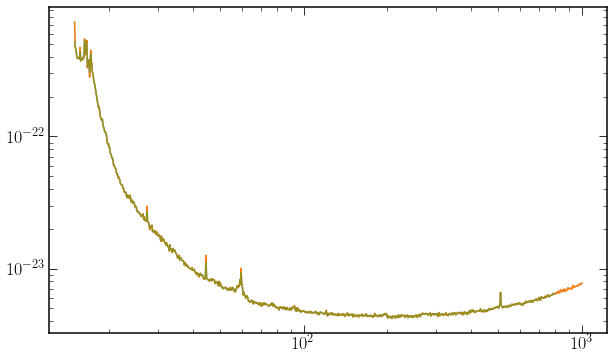

In [6]:
plt.figure(figsize=(10, 6))
plt.loglog(my_asdfref[0], my_asdfref[1], alpha=0.5)
plt.loglog(jay_asdfref[0], jay_asdfref[1])
plt.loglog(f_axis, my_asdf_interp, alpha=0.5)

### 1.2 Generate $f_{amp}$-bins for amplitudes

In [7]:
# This does a more robust form of np.interp, 
# i.e. one-dimensional linear interpolation on log asd - log f, instead on asd - f
tg.DEFAULT_ASDF = utils.asdf_fromfile(asd_file) # new tg class new attribute, default asdf for banks generation

# Measure for cosines of amplitudes

# Load reference asd data
asd_data = np.load(asd_file)
f_full = asd_data[0] # geometrically spaced f-grid 
psd = asd_data[1]**2

# Define quantites used to compute (self) match
df = tg.get_df(f_full) # needed because f_full is unequally-spaced (geometrically)
overlap_measure = 4 * df / psd
Aref = (f_full/100)**(-7/6) # used later for normalizing the waveforms
measure = overlap_measure * (Aref**2)
cum_measure = np.cumsum(measure)
measure = measure/cum_measure[-1] # relative contribution of each f-bin to Aref self match
cum_measure = cum_measure/cum_measure[-1]

# Finding first element with non-zero cum_measure (for interpolation to not break)
_ = (cum_measure>0) 
ind = 0
for i in range(len(_)):
    if (_[i]==True): ind=i-1; break

# Polynomial (degree=3) spline interpolation of normalized f_full vs cumulative match
fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure[ind:],f_full[ind:])

# Choose frequency bins with equal measure via inverse transform sampling
n_f_amp = 2000
f_amp = fsInterpolate(np.linspace(0.0001,1,n_f_amp)) # Frequency grid at which the amplitudes are interpolated
Aref = (f_amp/100)**(-7/6)

psd = tg.DEFAULT_ASDF(f_amp)**2
df = tg.get_df(f_amp)

# weights is a misnomer; should really be called measure (consistent with above) or square weights
# Note its definition contains Aref**2
weights = 4 * df * Aref**2 / psd 
weights = weights/np.sum(weights)

# Note that weights are approximately 1/n_f_amp = 1/2000

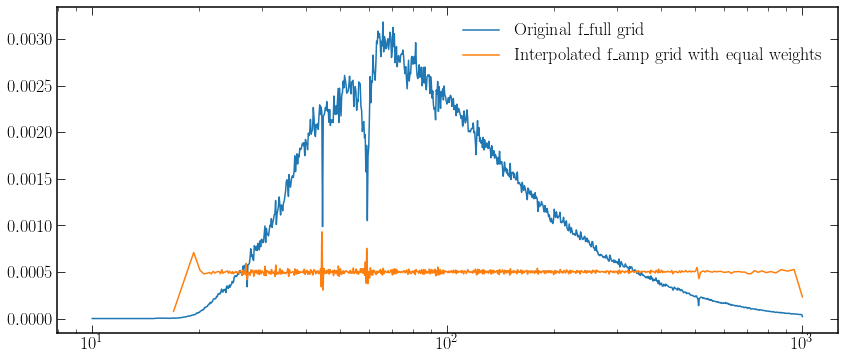

In [13]:
# Compare self match in original ref asd f-grid vs uniformly weights f-grid
_ = plt.figure(figsize=(12,))
_ = plt.plot(f_full, measure, label='Original f_full grid')
_ = plt.plot(f_amp, weights, label='Interpolated f_amp grid with equal weights')
_ = plt.xscale('log')
_ = plt.legend(loc='upper right')

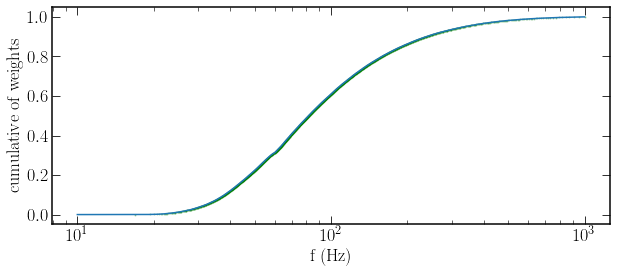

In [9]:
# Make sure interpolation works well
_ = plt.figure(figsize=(10,4))
_ = plt.plot(f_full,cum_measure)
_ = plt.scatter(f_amp,np.cumsum(weights),s=1,c='g', alpha=0.3)
_ = plt.xlabel('f (Hz)')
_ = plt.ylabel('cumulative of weights')
_ = plt.xscale('log')

## 2. Construct template bank from scratch

### 2.1 Input Parameters and Amplitudes

#### Generate parameters from choice of prior

In [8]:
def generate_params(nwf):
    ## Prior for m1, m2

    input_pars = np.empty((2*nwf, 4))

    # # OLD: Uniform in m1,m2 component
    # m_min, m_max= 1, 10
    # m = np.random.uniform(low=np.array([m_min, m_min]), high=np.array([m_max, m_max]), size=(nwf, 2))
    # m_ordered = np.stack([m.max(axis=1), m.min(axis=1),]).T

    # Uniform in eta, Mtot component
    eta_samp = np.random.uniform(eta_min, 0.25, nwf)
    M_samp = np.random.uniform(M_min,M_max, nwf)

    # Add more in small mchirp parameters (important for low mchirp subbank splitting)
    qmin = q_from_eta(eta_min)
    lnqrandom = np.random.uniform(np.log(qmin),np.log(0.99),nwf) # Prior for lnq
    Mchrandom = np.random.uniform(Mchmin,Mchmax,nwf)
    q_samp_sub = np.exp(lnqrandom)
    eta_samp_sub = q_samp_sub/(1+q_samp_sub)**2 # symmetric mass ratio
    _=Mchrandom/eta_samp_sub**(3/5)
    M_samp = np.append(M_samp,_)
    eta_samp = np.append(eta_samp, eta_samp_sub)

    m1random = (M_samp + np.sqrt(M_samp ** 2 - 4 * (eta_samp * M_samp ** 2))) / 2
    m2random = (M_samp - np.sqrt(M_samp ** 2 - 4 * (eta_samp * M_samp ** 2))) / 2

    #############################################

    ## Prior for love1 and love2; uniform in log 
    l1lograndom, l2lograndom = np.random.uniform(lovelog_min, lovelog_max, 2*nwf), np.random.uniform(lovelog_min, lovelog_max, 2*nwf)

    # Save parameters as m1, m2, l1, l2
    input_pars[:, 0] = m1random
    input_pars[:, 1] = m2random
    input_pars[:, 2] = 10**l1lograndom
    input_pars[:, 3] = 10**l2lograndom
    
    return input_pars

In [9]:
# # Creating samples of input parameters with appropriate priors

# nwf=500000
# input_pars = generate_params(nwf)

# m1random, m2random = input_pars[:,0], input_pars[:,1]
# l1random, l2random = input_pars[:,2], input_pars[:,3]

# Mrandom, etarandom = m1random+m2random, eta(m1random, m2random)
# Mchrandom = Mrandom * etarandom**0.6
# leffrandom = leff(m1random, m2random, l1random, l2random)

#### Masking (1st Round: 3 < Mchirp < 15 and Mtot < 40)

In [10]:
mass_mask = (Mchrandom>mch_cutoff)&(Mchrandom<mch_cutoff_upper)&(Mrandom<M_max)

In [11]:
# # Once satisfied with density of param space above, save
# input_pars = input_pars[mass_mask]
# np.save(os.path.join(DIR, HIGHM_DIR, 'pars_samples.npy'), input_pars)

input_pars = np.load(os.path.join(DIR, HIGHM_DIR, 'pars_samples.npy'))

m1random, m2random = input_pars[:,0], input_pars[:,1]
l1random, l2random = input_pars[:,2], input_pars[:,3]

Mrandom, etarandom = m1random+m2random, eta(m1random, m2random)
Mchrandom = Mrandom * etarandom**0.6
leffrandom = leff(m1random, m2random, l1random, l2random)

#### Generate/load amplitudes

In [ ]:
# # This cell is used for generating the amplitudes
# # not needed if you want to load the amplitudes from the cell below

# def amps_love(fs, input_par):
#     Mtot = input_par[0]+input_par[1]
#     eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
#     amp, _, _ = lovewf.hf3hPN_TLN(fs, M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)
#     return np.abs(amp)

# def fcutoffs_love(fs, input_par):
#     Mtot = input_par[0]+input_par[1]
#     eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
#     _, _, fcutoff = lovewf.hf3hPN_TLN(fs, M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)
#     return fcutoff

# start = time.perf_counter()
# with multiprocess.Pool(10) as p:
#     amps_samples = np.abs(p.starmap(amps_love, 
#                                     ((f_amp, input_par) for input_par in input_pars)))
#     fcutoff_samples = p.starmap(fcutoffs_love, 
#                                 ((f_amp, input_par) for input_par in input_pars))
    
# end = time.perf_counter()
# print(f'Duration: {end-start} (s)')

# np.save(os.path.join(DIR, HIGHM_DIR, 'amps_samples.npy'), amps_samples)
# np.save(os.path.join(DIR, HIGHM_DIR, 'fcutoff_samples.npy'), fcutoff_samples)

#### Masking (2nd Round: fcutoff < 60)

In [9]:
# # Mask off samples with f_cutoff < fmin_cutoff 60Hz
# # We basically say we ignore heavy systems which merge below fmin_cutoff and where the inspiral-only waveform becomes unreliable
# # Turns out this is insufficient; below we will also remove banks 6-9 because their effectualness plots are bad
# # This roughly translates to applying an effective fmin_cutoff ~ 60Hz


# fcutoff_samples = np.asarray(fcutoff_samples)
# fcutoff_mask = fcutoff_samples > fmin_cutoff

# input_pars = input_pars[fcutoff_mask]
# amps_samples = amps_samples[fcutoff_mask]
# fcutoff_samples = fcutoff_samples[fcutoff_mask]

# # Overwrite previous files, significantly reducing disk space
# np.save(os.path.join(DIR, HIGHM_DIR, 'pars_samples.npy'), input_pars)
# np.save(os.path.join(DIR, HIGHM_DIR, 'amps_samples.npy'), amps_samples)
# np.save(os.path.join(DIR, HIGHM_DIR, 'fcutoff_samples.npy'), fcutoff_samples)

#### Load parameters and amplitudes after mass and f_cutoff masking

In [9]:
# Load parameters after mass and fcutoff masking
input_pars = np.load(os.path.join(DIR, HIGHM_DIR, 'pars_samples.npy'))
amps_samples = np.load(os.path.join(DIR, HIGHM_DIR, 'amps_samples.npy'))
fcutoff_samples = np.load(os.path.join(DIR, HIGHM_DIR, 'fcutoff_samples.npy'))

m1random, m2random = input_pars[:,0], input_pars[:,1]
l1random, l2random = input_pars[:,2], input_pars[:,3]

Mrandom, etarandom = m1random+m2random, eta(m1random, m2random)
Mchrandom = Mrandom * etarandom**0.6
leffrandom = leff(m1random, m2random, l1random, l2random)

Text(0, 0.5, 'm2')

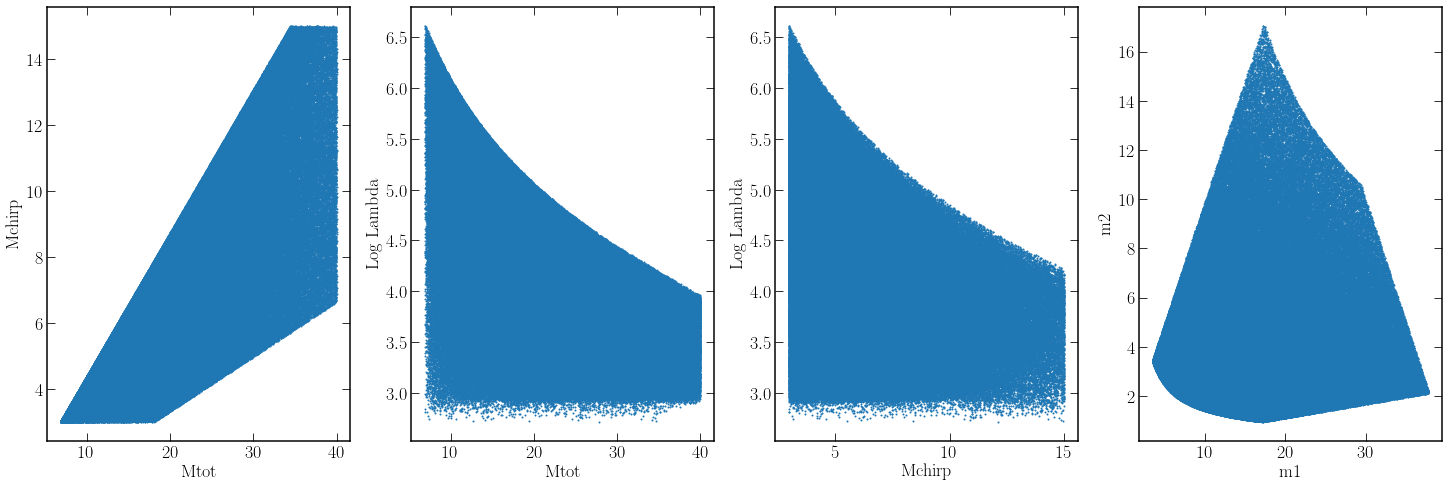

In [10]:
fig, ax = plt.subplots(1,4, figsize=(25,8))
ax[0].scatter(Mrandom, Mchrandom, s=1)
ax[0].set_xlabel('Mtot')
ax[0].set_ylabel('Mchirp')

ax[1].scatter(Mrandom, np.log10(leffrandom), s=1)
ax[1].set_xlabel('Mtot')
ax[1].set_ylabel('Log Lambda')

ax[2].scatter(Mchrandom, np.log10(leffrandom), s=1)
ax[2].set_xlabel('Mchirp')
ax[2].set_ylabel('Log Lambda')

ax[3].scatter(m1random, m2random, s=1)
ax[3].set_xlabel('m1')
ax[3].set_ylabel('m2')

### 2.2 Making Banks - split amplitude using KMeans

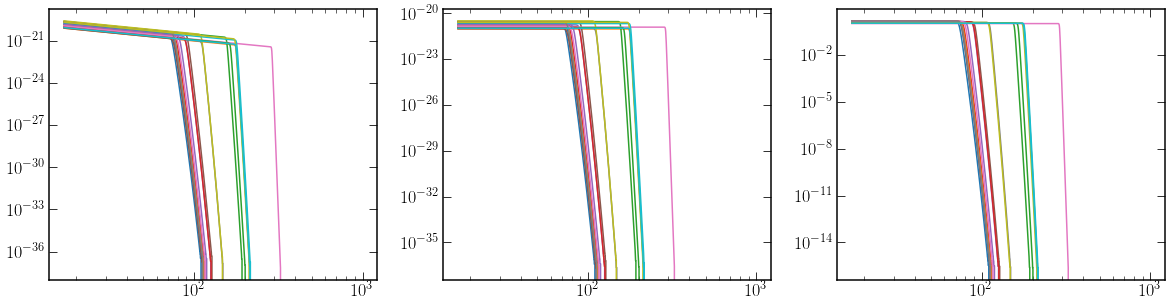

In [12]:
# Show random samples of waveform amplitudes
fig, ax = plt.subplots(1,3, figsize=(20,5))
amps_samples_scaled = amps_samples/Aref # Waveforms amplitudes with f^{-7/6} factor peeled off
norm = np.sum(weights*amps_samples_scaled**2,axis=-1)**0.5 # recall weights = normalize(4*df*Aref**2 / psd )
amps_samples_norm = amps_samples_scaled / norm[:,None] # Further normalize by the sqrt of self inner product for normalized waveforms

for i in range(20):
    _ = ax[0].loglog(f_amp, amps_samples[i]) # Some raw amplitudes
    _ = ax[1].loglog(f_amp, amps_samples_scaled[i]) 
    _ = ax[2].loglog(f_amp, amps_samples_norm[i]) 

In [13]:
# Choose which nbanks we want to use
nbanks = 6 # determined by our judgement from the cdf of amplitude match below

#### Use KMeans to split param space into banks

In [14]:
# # Splitting the banks using K-Means clustering algorithm on amplitudes of *normalized* waveforms
# # either run the kmeans again or load it

# # Important to perform kmeans on *amps_samples_norm*, i.e. divided by Aref and wf normalized to unity
# # kmeans for each frequency point; maybe use ::2 to avoid overfitting (not so important)
# kmeans = KMeans(n_clusters=nbanks, random_state=0).fit(amps_samples_norm)  

# with open(os.path.join(DIR, HIGHM_DIR, 'kmeans.pkl'), 'wb') as f: 
#     pickle.dump(kmeans, f) 

with open(os.path.join(DIR, HIGHM_DIR, 'kmeans.pkl'), 'rb') as f:
       kmeans = pickle.load(f)

In [15]:
# Compute Af_kmeans
Af_kmeans = np.asarray([x/np.sum(x**2*weights)**0.5 for x in kmeans.cluster_centers_]) # normalize Af_kmeans amplitudes
Af_kmeans_cumsum = np.cumsum(Af_kmeans**2*weights,axis=1)

# Just because amps_samples_norm are normalized, doesn't mean Af_kmeans are perfectly normalized (although they should be approximately so)
# Note most Af_kmeans agree with kmeans.cluster_centers_
print([np.allclose(Af_kmeans[i], kmeans.cluster_centers_[i], rtol=0.05) for i in range(len(Af_kmeans))])

# Create bank ids in ascending order of size of Af_kmeans
order = np.argsort(np.argmin((Af_kmeans_cumsum-0.97)**2,axis=1))[::-1] 
Af_kmeans = Af_kmeans[order]
Af_kmeans_cumsum = Af_kmeans_cumsum[order]

[True, True, True, True, True, True]


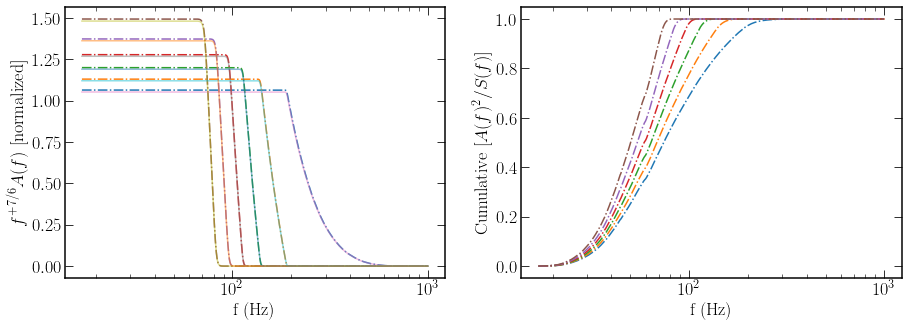

In [16]:
_ = plt.figure(figsize=(15,5))

_ = plt.subplot(121)
for Af in Af_kmeans:
    _ = plt.plot(f_amp,Af,'-.')
_ = plt.xlabel('f (Hz)'); _ = plt.ylabel(' $f^{+7/6} A(f) $   [normalized]')
_ = plt.xscale('log')

# Confirming that our kmeans center are mostly the same as those of Af_kmeans
# Any difference arises from the fact that the predicted kmeans.cluster_centers_ are not perfectly normalized
for i in range(len(kmeans.cluster_centers_)):
    _ = plt.plot(f_amp, kmeans.cluster_centers_[i], alpha=0.5) 

#Af_kmeans_cumsum=np.cumsum(Af_kmeans**2*weights,axis=1)
_ = plt.subplot(122)
for Af in Af_kmeans_cumsum:
    _ = plt.plot(f_amp,Af,'-.')
_ = plt.xlabel('f (Hz)'); _ = plt.ylabel('Cumulative [$ A(f)^2/S(f) $]')
_ = plt.xscale('log')

In [17]:
# # Predict which bank amps_samples should belong to

# bank_ids = kmeans.predict(amps_samples_norm)
# bank_ids = np.asarray([np.where(order == b)[0][0] for b in bank_ids]) # step needed because sklearn kmeans location is different from our bank id convention
# np.save(os.path.join(DIR, HIGHM_DIR, 'bank_ids.npy'), bank_ids)

bank_ids = np.load(os.path.join(DIR, HIGHM_DIR, 'bank_ids.npy'))

In [18]:
# Compute cosine (match) between Af_kmeans and A_samples, then find the bank to which each waveform belongs to (have maximum overlap)
# Phase is ignored in overlap; i.e. assume perfect phase coherence between kmeans clusters and its samplesa

cosines_kmeans_max=np.einsum('ij,kj,j', Af_kmeans, amps_samples_norm, weights) 
cosines_kmeans_max=np.max(cosines_kmeans_max,axis=0) # find best fit Af_kmeans

In [19]:
Af_kmeans.shape, amps_samples_norm.shape, weights.shape, cosines_kmeans_max.shape

((6, 2000), (303373, 2000), (2000,), (303373,))

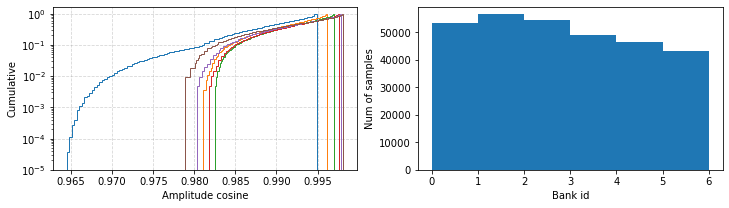

In [19]:
# Cosines for waveform amplitudes with Af_kmeans. Measure to choice of k

plt.figure(figsize=(12,3))
plt.subplot(121)
for ib in range(nbanks):
    _=plt.hist(cosines_kmeans_max[bank_ids==ib],bins=100,histtype='step',density=True, cumulative=True)
    plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
    plt.yscale('log'); plt.xlabel('Amplitude cosine'); plt.ylabel('Cumulative'); plt.ylim(bottom=1e-5)

plt.subplot(122)
_=plt.hist(bank_ids,bins=np.linspace(0,nbanks,nbanks+1))
plt.xlabel('Bank id'); plt.ylabel('Num of samples');

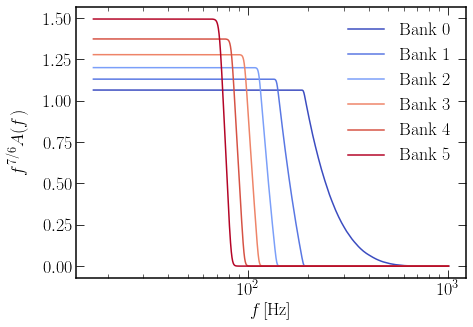

In [184]:
import matplotlib
# color_levels = np.linspace(0.0, 1.0, 6)
color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
# tab10 = list(matplotlib.cm.get_cmap("RdYlBu")(color_levels))
tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# color_levels = np.linspace(0.2, 0.8, 6)
# tab10_iter = iter(matplotlib.cm.get_cmap("cubehelix")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)

fig, ax= plt.plot(figsize=(10,8))
for i, Af in enumerate(Af_kmeans):
    _ = plt.plot(f_amp,Af,'-', c=next(tab10_iter), label=f'Bank {i}')
    
_ = plt.xlabel('$f$\,[Hz]')
_ = plt.ylabel(r'$f^{7/6}A(f)$', labelpad=15)
_ = plt.xscale('log')
_ = plt.legend()

# handles_1d, labels_1d = ax.get_legend_handles_labels()
# # handles_1d = swapPositions(handles_1d,2,3)
# # labels_1d = swapPositions(labels_1d,2,3)
# fig.legends = []
# fig.legend(handles_1d, labels_1d, loc='upper left', bbox_to_anchor=(0.13,.88), frameon=False, prop=font)

# ax.set_xlabel('$\chi_{p}$', fontsize=fontsize_label, labelpad=labelpad)
# ax.set_ylabel('Posterior Density Function', fontsize=fontsize_label, labelpad=labelpady)
# plt.setp(ax.get_xticklabels(), size=ticksize)
# plt.setp(ax.get_yticklabels(), size=ticksize)
# fig

### 2.3 Show bank parameter space

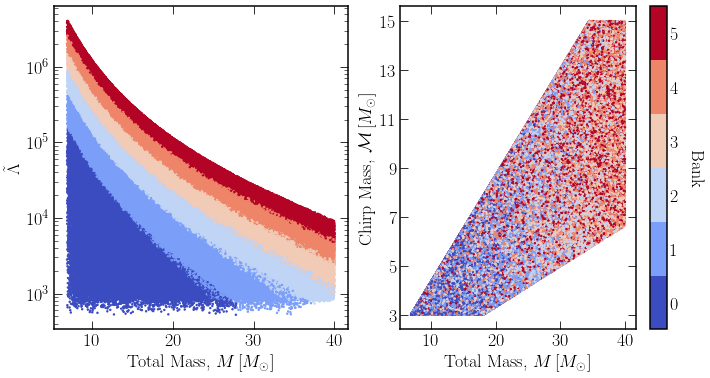

In [27]:
# Plot will be updated below if additional masking is applied 

# Black points suggests either we ignore them or create a new bank to account for them
# bad=cosines_kmeans_max < 0.96

# Color settings

# tab10 = list(mpl.cm.get_cmap('Set2').colors)[:6]
import matplotlib
color_levels = np.linspace(0.0, 1.0, 6)
# color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
tab10 = list(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)

# Create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))

# Define the bins and normalize
# bounds = np.linspace(0., 6, 6)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# fig, ax = plt.subplots(1,3,figsize=(22,6))

fig = plt.figure(figsize=(10,10))
plt.rcParams["figure.autolayout"] = True


ax1 = plt.subplot(221)
_ = ax1.scatter(Mrandom,leffrandom,c=bank_ids,s=2,cmap=cmap, rasterized=True); # _ = plt.colorbar()
# ax1.text(25,400000,r'$f_c < 60$ Hz', fontsize=18)
# ax1.plot(X_, Y_, alpha=0.3, color='k')
_ = ax1.set_xlabel('Total Mass, $M\,[M_{\odot}]$'); _ = ax1.set_ylabel(r'$\tilde{\Lambda}$')
_ = ax1.set_yscale('log')
_ = ax[1].set_xlim(7, 40)
_ = ax[1].set_ylim(500, 1e7)

ax0 = plt.subplot(222)
ax2 = ax0.scatter(Mrandom,Mchrandom,c=bank_ids,s=2,cmap=cmap, rasterized=True); #_ = plt.colorbar()
_ = ax0.set_xlabel('Total Mass, $M\,[M_{\odot}]$'); _ = ax0.set_ylabel('Chirp Mass, $\mathcal{M}\,[M_{\odot}]$')
_ = ax0.set_yticks(np.arange(3,17,2))
# ax0.set_aspect(3.5)

# _ = ax[0].set_xlim([7,40])
# _ = ax[0].set_ylim([3,15])

# ax2, _ = mpl.colorbar.make_axes(plt.gca())
# cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
# for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
#     label.set_visible(False)



# ax2, _ = mpl.colorbar.make_axes(plt.gca())
# cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,  spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
cbar = plt.colorbar(ax2, cmap=cmap,  spacing='proportional', ticks=[0.4167, 1.25, 2.083, 2.917, 3.75, 4.583] , format='%1i')
cbar.ax.set_yticklabels(["0","1","2","3","4","5"])
# ax1.set_aspect(1)
# cbar = plt.colorbar(ax2)
cbar.set_label('Bank', rotation=270, labelpad=25)
for label in cbar.ax.yaxis.get_ticklines():
    label.set_visible(False)

# fig.tight_layout(pad=1.0)

In [28]:
fig.savefig('bank_params_top_2.pdf', bbox_inches='tight', dpi=300)

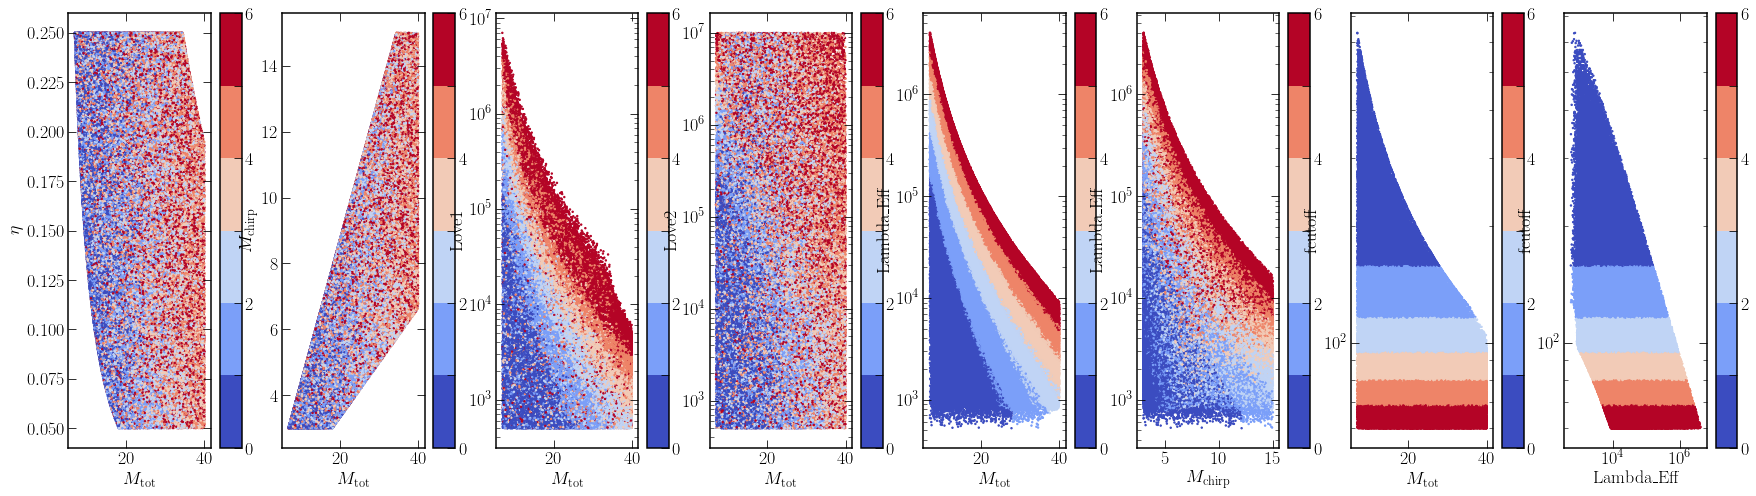

In [119]:
# Plot will be updated below if additional masking is applied 

# Black points suggests either we ignore them or create a new bank to account for them
bad=cosines_kmeans_max < 0.96

# Color settings

# tab10 = list(mpl.cm.get_cmap('Set2').colors)[:6]
import matplotlib
color_levels = np.linspace(0.0, 1.0, 6)
# color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
tab10 = list(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)

# Create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))

# Define the bins and normalize
bounds = np.linspace(0, 6, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Figure
fig = plt.figure(figsize=(30,8))

_ = plt.subplot(181)
_ = plt.scatter(Mrandom,etarandom,c=bank_ids,s=2,cmap=cmap); #_ = plt.colorbar()
_ = plt.scatter(Mrandom[bad],etarandom[bad],s=10,c='k', alpha=0.3);
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('$\eta$')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(182)
_ = plt.scatter(Mrandom,Mchrandom,c=bank_ids,s=2,cmap=cmap); #_ = plt.colorbar()
_ = plt.scatter(Mrandom[bad],Mchrandom[bad],s=10,c='k', alpha=0.3);
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('$M_\mathrm{chirp}$')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(183)
_ = plt.scatter(Mrandom,l1random,c=bank_ids,s=2,cmap=cmap);  #_ = plt.colorbar()
lowLove2 = True #l2random < 2e6
_ = plt.scatter(Mrandom[bad&lowLove2],l1random[bad&lowLove2],c='k',s=10, alpha=0.3)
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('Love1')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

# Love of 1e6 is fine
_ = plt.subplot(184)
_ = plt.scatter(Mrandom,l2random,c=bank_ids,s=2,cmap=cmap);  #_ = plt.colorbar()
lowLove1 = True #l1random < 2e6
_ = plt.scatter(Mrandom[bad&lowLove1],l2random[bad&lowLove1],c='k',s=10, alpha=0.3)
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('Love2')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(185)
_ = plt.scatter(Mrandom,leffrandom,c=bank_ids,s=2,cmap=cmap); # _ = plt.colorbar()
_ = plt.scatter(Mrandom[bad],leffrandom[bad],c='k',s=10, alpha=0.3)
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('Lambda_Eff')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(186)
_ = plt.scatter(Mchrandom,leffrandom,c=bank_ids,s=2,cmap=cmap);  #_ = plt.colorbar()
_ = plt.scatter(Mchrandom[bad],leffrandom[bad],c='k',s=10, alpha=0.3)
_ = plt.xlabel('$M_\mathrm{chirp}$'); _ = plt.ylabel('Lambda_Eff')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(187)
_ = plt.scatter(Mrandom,np.array(fcutoff_samples),c=bank_ids,s=2,cmap=cmap);  #_ = plt.colorbar()
_ = plt.scatter(Mrandom[bad],np.array(fcutoff_samples)[bad],c='k',s=10, alpha=0.3)
_ = plt.xlabel('$M_\mathrm{tot}$'); _ = plt.ylabel('fcutoff')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

_ = plt.subplot(188)
_ = plt.scatter(leffrandom,np.array(fcutoff_samples),c=bank_ids,s=2,cmap=cmap);  #_ = plt.colorbar()
# _ = plt.scatter(leffrandom[bad],np.array(fcutoff_samples)[bad],c='k',s=10, alpha=0.3)
_ = plt.xlabel('Lambda_Eff'); _ = plt.ylabel('fcutoff')
_ = plt.xscale('log')
_ = plt.yscale('log')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

In [42]:
fig.savefig(os.path.join(DIR, HIGHM_DIR, 'param_space.pdf'), bbox_inches='tight')

### 2.4 SVD for phases

#### Frequency grids, weights and constant/linear basis for each bank

In [18]:
# Functions dealing with constant and linear basis

# Obtain 0, 1 bases
def gram_schmidt_columns(X,measure):
    ws=measure**0.5
    Q, R = np.linalg.qr((X*ws).T) # Q would be singular vectors v 
    return Q.T/ws # /ws to avoid double weighting later

# Project out the constant and linear basis from phase
def project_out(v,basis,measure):
    # measure is included to cancel wt*2 from the two basis terms
    return v - ((v*measure) @ basis.T) @ basis

In [19]:
# Choose a different set of frequency bins for each bank 
# Same idea as before except there f_amp is based on Aref, whereas now we use Af_kmeans (more fine grid for low f_cutoff Af_kmeans)

n_fs_basis = 1000 # Number of frequency bins for phase

f_phases_banks = []
f_unwrap_banks = []
basis_banks = []
weights_banks = [] # Note this is square of wts used in template_bank_generator_love.py


for ib in range(nbanks): # Change if needed
    Af_bank=Af_kmeans[ib]
    # Recall Af_bank is normalized, while Aref is scaled
    Af_bank_interp=interpolate.InterpolatedUnivariateSpline(f_amp , Af_bank*Aref, k=3)

    # Create new frequency grid for each bank (as procedure as for f_amp)
    mask = f_full > f_amp[0]
    fs_fine = f_full[mask]
    df = tg.get_df(fs_fine)
    psd = tg.DEFAULT_ASDF(fs_fine)**2
    measure_bank = 4 * df / psd * Af_bank_interp(fs_fine)**2
    measure_bank = measure_bank/np.sum(measure_bank)
    cum_measure_bank = np.cumsum(measure_bank)
    
    _ = (cum_measure_bank>1e-6) # Finding first element with non-zero cum_measure
    ind0=0; ind1=len(cum_measure_bank)
    for i in range(len(_)):
        if (_[i]==True and i>0): ind0=i-1; break
        
    _=(cum_measure_bank>1-1e-6) # Finding elements before cum_measure = 1
    for i in range(len(_)):
        if (_[i]==True and i<len(cum_measure_bank)): ind1=i+1; break

    # Sample frequency grid, with each f-bin having equal measure
    fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure_bank[ind0:ind1],fs_fine[ind0:ind1])
    f_phase=fsInterpolate(np.linspace(0.001,0.999,n_fs_basis)) # Lose 0.2% of effectualness; if start from match=0 f_min would be very small
    # Occassionally f_phase can be monotonic (especially near measure~0.999) leading to negative weights, which is unphysical 
    # May be due to noisy sampling?
    f_phase.sort() 
    
    # Compute weights using f_phase
    psd = tg.DEFAULT_ASDF(f_phase)**2
    df = tg.get_df(f_phase)
    weights_bank = 4 * df / psd * Af_bank_interp(f_phase)**2
    weights_bank /= np.sum(weights_bank) # these values should be close to 1e-3

    # very fine frequency grid used when generating waveform phases for phase interpolation
    fmax=f_phase[-1]
    fmin=f_phase[0]
    fmid=np.exp(0.5*(np.log(fmax)+np.log(fmin))) # geometric mean
    mchirp_ib = Mchrandom[bank_ids==ib]
    mchirp_min=np.min([np.min(mchirp_ib),20.])
    f_unwrap_bank = tg.get_efficient_frequencies(fmin=fmin, fmid=fmid, fmax=fmax,
                              mchirp_min=mchirp_min ,delta_radians=0.5) 

    vs_bank = np.asarray([np.ones(len(f_phase)),f_phase]) # constant and linear basis
    basis_bank = gram_schmidt_columns(vs_bank,weights_bank) # obtain constant and linear basis in V representation
    
    f_phases_banks.append(f_phase)
    f_unwrap_banks.append(f_unwrap_bank)
    basis_banks.append(basis_bank)
    weights_banks.append(weights_bank)

In [45]:
# Watch out for negative weights
for i in range(nbanks):
    print('Bank ',i, np.sum(weights_banks[i] < 0))

Bank  0 0
Bank  1 0
Bank  2 0
Bank  3 0
Bank  4 0
Bank  5 0


In [47]:
# For saving a part of Multibank data

for i in range(nbanks):
    os.makedirs(os.path.join(DIR, HIGHM_DIR, 'love_'+str(i)))
    np.save(os.path.join(DIR, HIGHM_DIR, 'love_'+str(i),'Af.npy'),np.c_[f_amp,Af_kmeans[i]*Aref])
    np.save(os.path.join(DIR, HIGHM_DIR, 'asd.npy'), asd_data)
    np.save(os.path.join(DIR, HIGHM_DIR, 'love_'+str(i),'f_phases.npy'),f_phases_banks[i])
    np.save(os.path.join(DIR, HIGHM_DIR, 'love_'+str(i),'f_unwrap_phases.npy'),f_unwrap_banks[i])
    np.save(os.path.join(DIR, HIGHM_DIR, 'love_'+str(i),'weights_phases.npy'),np.sqrt(weights_banks[i])) # Note the sqrt

Text(0.5, 1.0, 'Lower, middle and upper limit freq for banks')

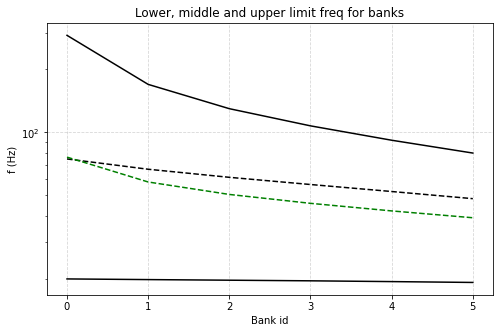

In [48]:
qaz=np.asarray(f_phases_banks)
plt.plot(range(len(Af_kmeans)),qaz[:,0],c='k')
plt.plot(range(len(Af_kmeans)),qaz[:,-1],c='k')
fmid=np.exp(np.mean(np.log(qaz),axis=1))
plt.plot(range(len(Af_kmeans)),fmid,'--',c='k')
fmid=np.exp(0.5*(np.log(qaz[:,0])+np.log(qaz[:,-1])))
plt.plot(range(len(Af_kmeans)),fmid,'--',c='g')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)

plt.yscale('log'); plt.xlabel('Bank id'); plt.ylabel('f (Hz)')
plt.title('Lower, middle and upper limit freq for banks')

#### Generate phases with input_pars

In [33]:
# # Either directly load the phases or generate them with the commented out code

# start = time.time()

# def gen_phases(bank_id, input_par):
#     Mtot = input_par[0]+input_par[1]
#     eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
#     _, phases, _ = lovewf.hf3hPN_TLN(f_unwrap_banks[bank_id], M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)
#     phases = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id],phases)
#     phases = project_out(phases,basis_banks[bank_id],weights_banks[bank_id]) # phase residual
#     return phases

# with multiprocess.Pool(10) as p:
#         phases_samples = p.starmap(gen_phases,
#                            ((bank_ids[i], input_pars[i]) for i in range(len(input_pars))))
# phases_samples = np.asarray(phases_samples)

# np.save(os.path.join(DIR, HIGHM_DIR, 'phases_samples.npy'),phases_samples)

# time.time() - start

# these samples still contain those for banks 18-23, though fmin_cutoff and mch_cutoff maskings are included
phases_samples = np.load(os.path.join(DIR, HIGHM_DIR, 'phases_samples.npy'))


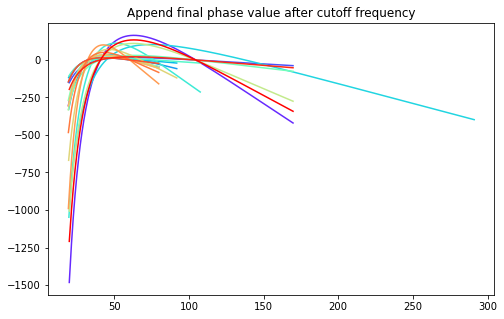

In [51]:
from matplotlib.pyplot import cm
num=20
fig = plt.figure(figsize=(8,5))
color = iter(cm.rainbow(np.linspace(0, 1, num)))
for i in range(num):
    c = next(color)
    _ = plt.plot(f_phases_banks[bank_ids[i]], phases_samples[i], c=c)
_ = plt.title('Append final phase value after cutoff frequency')

In [52]:
fig.savefig(os.path.join(DIR, HIGHM_DIR, 'append_final_phase_after_cutoff.pdf'), bbox_inches='tight')

#### SVD of residual phase

In [53]:
# SVD of the normalized phases (currently without splitting into sub-banks)

start = time.time()

all_U=[]; all_s=[]; all_Vh=[]
all_means=[]

for ib in range(nbanks):
    wt = weights_banks[ib]**0.5
    mask = (bank_ids==ib)
    phases = phases_samples[mask]
    scaled_phases = phases*wt
    mean_phases = np.mean(scaled_phases,axis=0) # averge phase of the bank
    
    Up, sp, Vph = np.linalg.svd(scaled_phases-mean_phases, full_matrices=False)
    
    all_U.append(Up); all_s.append(sp); all_Vh.append(Vph); all_means.append(mean_phases)
    
time.time() - start

31.206984996795654

#### Truncation, gridding and random forest regression

CPU times: user 5min 8s, sys: 19min 51s, total: 25min
Wall time: 1min 55s


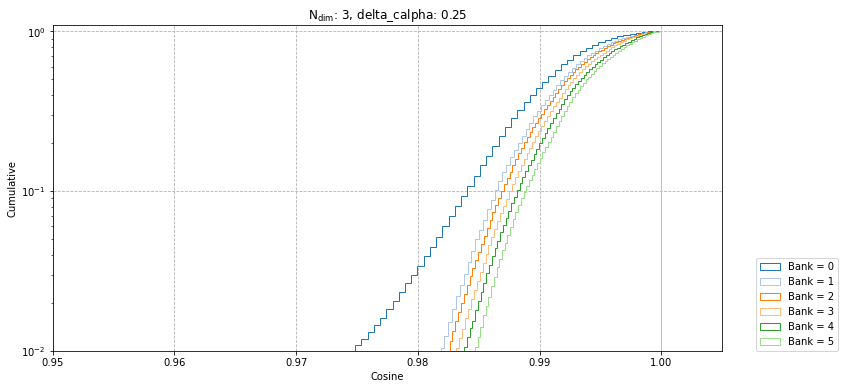

In [54]:
%%time

# Show match in phases (assume overlap in amplitudes are 1)
# Check that truncation (ndims) and calpha gridding (deltac_inv) in phases doesn't lead to significant drop in match 

ndims = 3 # Number of SVD dims used
deltac_inv = 4

examples=list(range(nbanks)) # Bank numbers
fig = plt.figure(figsize=(12,6))
for ib in examples:    
    Up = all_U[ib]; sp = all_s[ib]; Vph = all_Vh[ib]
    scaled_phases=Up @ np.diag(sp) @ Vph + all_means[ib]
    
    ca = Up @ np.diag(sp) # ca are c_alphas (also called coeffs)
    ca[:,ndims:] = 0
    ca = np.rint(ca*deltac_inv)/ deltac_inv # Gridding in equal rounded spacings in deltac_inv
    scaled_phases_f = ca @ Vph + all_means[ib]
    
    wt = weights_banks[ib]**0.5

    phases_f = scaled_phases_f/wt
    phases = scaled_phases/wt
    
    # no np.max needed because each waveform is already classified to its respective bank through kmeans
    cos_exp_f = np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f)*wt, np.conj(np.exp(1j*phases)*wt)))

    _ = plt.hist(cos_exp_f,bins=100,density=True,histtype='step',label='Bank = '+str(ib),cumulative=True, color=cmaplist[ib])

plt.yscale('log'); plt.grid(visible=True, which='major', linestyle='--',alpha=1)
plt.ylim(0.01,1.1); plt.xlim(0.95,1.005)
plt.xlabel('Cosine'); plt.ylabel('Cumulative'); plt.title('N$_\mathrm{dim}$: '+str(ndims) + f', delta_calpha: {1/deltac_inv}'); plt.legend(loc=(1.05,0))

In [55]:
# Truncation and gridding in phase introduces <2% loss in match for less than 1% of the waveforms
fig.savefig(os.path.join(DIR, HIGHM_DIR, f'append_final_phase_after_cutoff_svd_ndim{ndims}_deltac{1/deltac_inv}.pdf'), bbox_inches='tight')

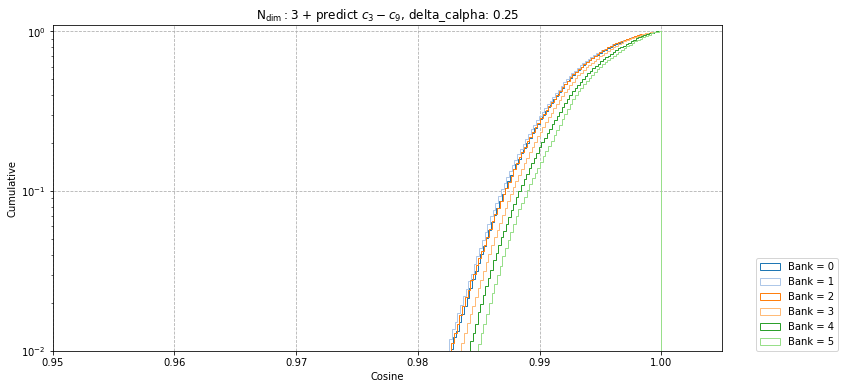

In [56]:
# Predicting c_i as a function of (norm, c_1) with a random forest

from copy import deepcopy as dcopy

rg_rf = RandomForestRegressor(n_estimators=300, max_depth=80, random_state=2)

ndims=3
ndim_final = 10
deltac_inv = 4

fig = plt.figure(figsize=(12,6))

examples=list(range(nbanks))
for ib in examples:    
    Up=all_U[ib]; sp=all_s[ib]; Vph=all_Vh[ib]
    wt=weights_banks[ib]**0.5
    ind=np.random.choice([0, 1], size=(len(Up),), p=[1./2, 1./2]).astype('bool') # train 50% for regressor, the remaining 50% as truth for comparison
    scaled_phases=(Up @ np.diag(sp) @ Vph + all_means[ib])[ind]
    
    ca=Up @ np.diag(sp)
    caf=dcopy(ca)[ind]
    caf[:,:ndims]=np.rint(caf[:,:ndims]*deltac_inv)/deltac_inv
    caf[:,ndims:]=0
    rg_rf.fit(ca[:, :ndims][~ind],ca[:,ndims:ndim_final][~ind]) # Regress all the way to c9 basis
    caf[:,ndims:ndim_final]=rg_rf.predict(caf[:,:ndims]) # From our gridded ndims calpha basis, we predict the rest
    scaled_phases_f=caf @ Vph + all_means[ib]
    
    phases_f=scaled_phases_f/wt
    phases=scaled_phases/wt

    cos_exp_f = np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f)*wt, np.conj(np.exp(1j*phases)*wt)))

    _ = plt.hist(cos_exp_f,bins=100,density=True,histtype='step',label='Bank = '+str(ib),cumulative=True, color=cmaplist[ib])

    #plt.legend(loc='upper left')
plt.yscale('log'); plt.grid(visible=True, which='major', linestyle='--',alpha=1)
plt.ylim(0.01,1.1); plt.xlim(0.95,1.005)
plt.xlabel('Cosine'); plt.ylabel('Cumulative'); 
plt.title('N$_\mathrm{dim}: $' + str(ndims) + f' + predict $c_{ndims}-c_{ndim_final-1}$' + f', delta_calpha: {1/deltac_inv}');
plt.legend(loc=(1.05,0))

In [57]:
# Truncation, gridding, and using rg estimator in phase introduces <4% loss in match for less than 1% of the waveforms
fig.savefig(os.path.join(DIR, HIGHM_DIR, f'append_final_phase_after_cutoff_svd_ndim{ndims}_withregressor_deltac{1/deltac_inv}.pdf'), bbox_inches='tight')

### 2.5 Estimate Waveform Support Times

In [20]:
# Waveform support times are used to split subbanks

fftsize_estimate = 2**18
dt_estimate = 1/512
f_grid = np.fft.rfftfreq(fftsize_estimate, d=dt_estimate)
psd = tg.DEFAULT_ASDF(f_grid)**2

# Copied from tg module
def remove_linear_component(phases, fs, wts, return_coeffs=False):
    """
    Fits out a linear dependence of phase w.r.t frequency
    :param phases:
        n_wf x len(fs) array with angles (Note that it needs to be a 2d array)
    :param fs: Array with frequencies
    :param wts:
        Weights for linear fit, note that for Gaussian w/ variance sigma^2,
        weights are 1/sigma
    :param return_coeffs: Flag to return coefficients of the linear terms
    :return: 1. n_wf x len(fs) array with unweighted residuals of linear fit
             2. If return_coeffs, n_wf x 2 array with coefficients of linear
                and constant terms (in that order)
    """
    # Remove tc and constant phase
    lin_fit = np.polyfit(x=fs, y=np.transpose(phases), deg=1, w=wts)  # 2xn_wf
    # Bestfit linear trend (n_wf x len(fs))
    # bestfit = np.dot(np.transpose(lin_fit), np.stack([fs, np.ones(len(fs))]))
    bestfit = np.array([np.poly1d(i)(fs) for i in np.transpose(lin_fit)])

    # Treat edges
    bestfit[:, wts == 0] = 0

    # Input to inner product (note, need to weight for SVD)
    residuals = (phases - bestfit)  # n_wf x len(fs)

    if return_coeffs:
        return residuals, lin_fit.T
    else:
        return residuals

# Find TD envelope of waveform
# Adapted from tg.get_waveform_conditioning
def waveform_time(fftsize, dt, whitened_wf_fd):
    whitened_wf_td_cos = utils.IRFFT(whitened_wf_fd, n=fftsize) / dt
    whitened_wf_td_sin = utils.IRFFT(whitened_wf_fd * 1j, n=fftsize) / dt
    envelope_sq = whitened_wf_td_cos ** 2 + whitened_wf_td_sin ** 2

    # Look at how weight builds up
    lind = 0
    rind = len(envelope_sq)
    totalwt = np.sum(envelope_sq)
    currentwt = 0
    while currentwt < (1. - params.WFAC_WF) * totalwt:
        dlwt = envelope_sq[lind]
        drwt = envelope_sq[rind - 1]
        if dlwt > drwt:
            lind += 1
            currentwt += dlwt
        else:
            rind -= 1
            currentwt += drwt
    tight_support_wf = fftsize - rind + lind
    return tight_support_wf * dt

def times_love(bank_id, input_par):
    Mtot = input_par[0]+input_par[1]
    eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
    
    _, phase_t, _ = lovewf.hf3hPN_TLN(f_phases_banks[bank_id], M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)    
    A_t, _, _ = lovewf.hf3hPN_TLN(f_phases_banks[bank_id], M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True) 
    phase_t = remove_linear_component((phase_t,), f_phases_banks[bank_id], np.sqrt(weights_banks[bank_id]))
    
    # print(f_grid.shape, f_phases_banks[bank_id].shape, phase_t.shape)
    phase_t_interp = np.interp(f_grid, f_phases_banks[bank_id], phase_t[0])
    A_t_interp = np.interp(f_grid, f_phases_banks[bank_id], A_t, left=0, right=0)
    hf_t = A_t_interp * np.exp(1j*phase_t_interp)
    hf_whitened = hf_t / (np.sqrt(psd * 2 * dt_estimate))
    return waveform_time(fftsize_estimate, dt_estimate, hf_whitened)

start = time.perf_counter()
with multiprocess.Pool(10) as p:
    times_samples = p.starmap(times_love, 
                                    ((bank_ids[i], input_pars[i]) for i in range(len(input_pars))))
print(time.perf_counter()- start)

np.save(os.path.join(DIR, HIGHM_DIR, 'times_samples.npy'), times_samples)

# Contains high banks samples
times_samples = np.load(os.path.join(DIR, HIGHM_DIR, 'times_samples.npy'))

/home/hschia/PE/gw_detection_ias/utils.py:965: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


1043.5214134640992


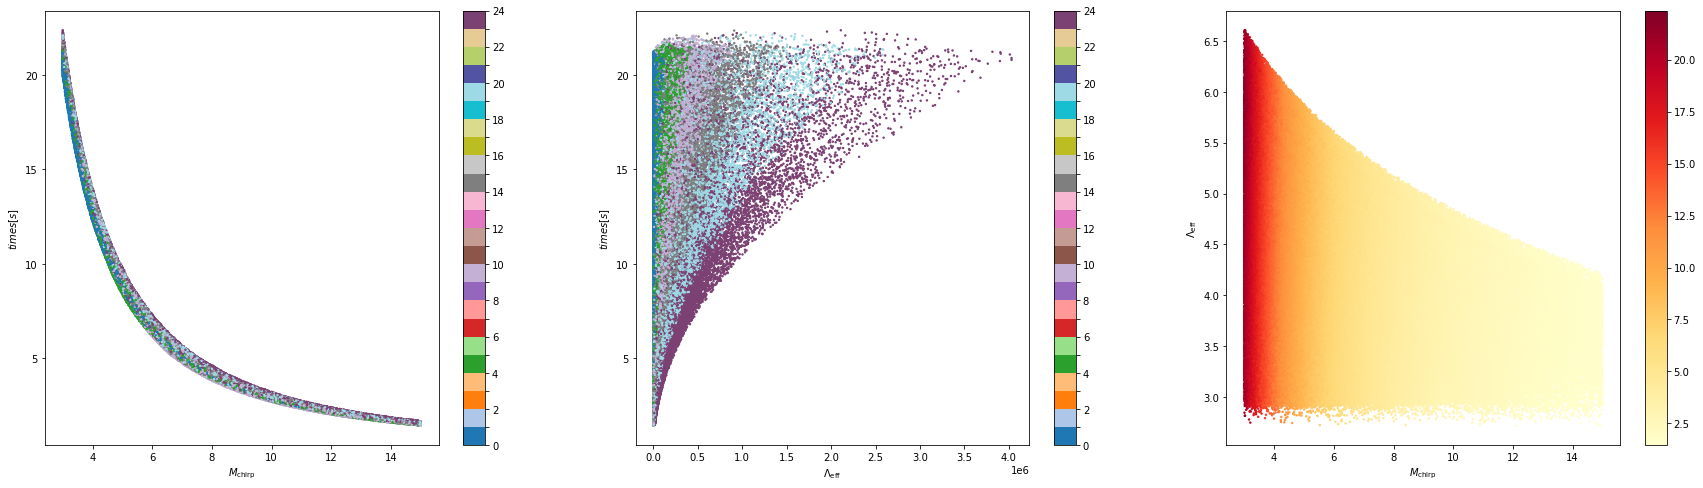

In [24]:
fig = plt.figure(figsize=(30,8))

tab20 = list(mpl.cm.get_cmap('tab20').colors)
tab20b = list(mpl.cm.get_cmap('tab20b').colors)
cmaplist = tab20 + tab20b[1::5]  # 24 colors (should be long enough)

# Create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, len(cmaplist))

# Define the bins and normalize
bounds = np.linspace(0, 24, 25)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

_ = plt.subplot(131)
_ = plt.scatter(Mchrandom,times_samples,c=bank_ids,s=2,cmap=cmap); #_ = plt.colorbar()
# bad=cosines_kmeans_max < 0.96
# _ = plt.scatter(Mchrandom[bad],times_samples[bad],s=10,c='k', alpha=0.3);
_ = plt.xlabel('$M_\mathrm{chirp}$'); _ = plt.ylabel('$times[s]$')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
_ = plt.subplot(132)
_ = plt.scatter(leffrandom,times_samples,c=bank_ids,s=2,cmap=cmap); #_ = plt.colorbar()
# bad=cosines_kmeans_max < 0.96
# _ = plt.scatter(leffrandom[bad],times_samples[bad],s=10,c='k', alpha=0.3);
_ = plt.xlabel('$\Lambda_\mathrm{eff}$'); _ = plt.ylabel('$times[s]$')

ax2, _ = mpl.colorbar.make_axes(plt.gca())
cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
for label in cbar.ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
_ = plt.subplot(133)
_ = plt.scatter(Mchrandom, np.log10(leffrandom), c=times_samples, s=2, cmap='YlOrRd')
_ = plt.xlabel('$M_\mathrm{chirp}$'); _ = plt.ylabel('$\Lambda_\mathrm{eff}$')
_ = plt.colorbar()

# pars_t_gtr400 = input_pars[~mask_times]
# plt.scatter(pars_t_gtr400[:,0]+pars_t_gtr400[:,1], np.log10(pars_t_gtr400[:,2]+pars_t_gtr400[:,3]))

In [25]:
fig.savefig(os.path.join(DIR, HIGHM_DIR, 'param_space_times.pdf'), bbox_inches='tight')

In [26]:
# As long as all waveform times < nfftsize * dt (in our case 32s) we will be fine
times_samples.max()

22.3671875

### 2.6 Making Subbanks - bin phases based on Mchirp

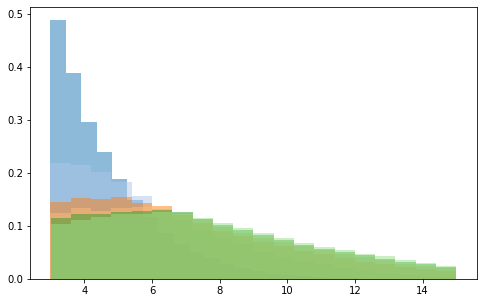

In [27]:
# Mchirp distribution in each bank
import math

SubBankSplits = []
for ib in range(nbanks):
    mask = (bank_ids == ib)
    input_pars_mask = input_pars[mask]
    times_samples_mask = np.asarray(times_samples)[mask]
    eta_mask = input_pars_mask[:,0]*input_pars_mask[:,1]/(input_pars_mask[:,0] + input_pars_mask[:,1])**2
    mchirp_mask = (input_pars_mask[:,0] + input_pars_mask[:,1])*eta_mask**(3/5)
    
    t5, t95 = np.percentile(times_samples_mask, 5), np.percentile(times_samples_mask, 95)
    SubBankSplits.append(int(round(np.log2(t95/t5))))
    
    _ = plt.hist(mchirp_mask, bins=20, color=cmaplist[ib], density=True, alpha=0.5)    

In [28]:
SubBankSplits

[2, 3, 3, 3, 3, 3]

In [29]:
# # Given the output above seems nicer to have the following split
SubBankSplits = [3] * nbanks
# SubBankSplits = [2,2,2,3,3,3]
# SubBankSplits = [2,2,2,10,10,10]

Note that for the purposes of creating the subbanks with better resolution in low Mchirp, much more advantagenous to have denser sampling in low Mchirp

In [30]:
# For copying the above cell to metadata
_ = ['love_'+str(i) for i in range(nbanks)]
_dic = dict(zip(_ , SubBankSplits))

In [31]:
## Assign samples to bins in scale within each bank

subbank_ids = np.zeros(len(bank_ids),dtype=int)
SubBank_Mchirp_bins = []
for ib in range(nbanks):
    mask = (bank_ids==ib)
    mchirp_bank = Mchrandom[mask]
    nbins = SubBankSplits[ib]
    bn = np.quantile(mchirp_bank,np.linspace(0,1,nbins+1)) # divide each subbank to have equal number of waveforms
    bins = list(zip(bn[:-1],bn[1:])) # Subbank bins divided by mchirp
    print('Bank ... ',ib,' n bins  ', len(bins))
    print(r'M_chirp ranges=',bn)
    subbank_id = np.zeros(len(mchirp_bank),dtype=int)
    for isb in range(len(bins)):
        mask2 = (mchirp_bank>(bins[isb][0])); mask2 *= (mchirp_bank<(bins[isb][1]));
        subbank_id[mask2] = isb
    subbank_ids[mask] = subbank_id
    SubBank_Mchirp_bins.append(bins)

with open(os.path.join(DIR,HIGHM_DIR, 'SubBank_Mchirp_bins.pkl'), 'wb') as f:
    pickle.dump(SubBank_Mchirp_bins, f)
    
with open(os.path.join(DIR,HIGHM_DIR,'SubBank_Mchirp_bins.pkl'), 'rb') as f:
    SubBank_Mchirp_bins = pickle.load(f)

Bank ...  0  n bins   3
M_chirp ranges= [ 3.00000151  3.72749877  4.93727369 12.09852265]
Bank ...  1  n bins   3
M_chirp ranges= [ 3.00015267  4.55420384  6.62117438 14.99658748]
Bank ...  2  n bins   3
M_chirp ranges= [ 3.00002427  5.22216324  7.80703112 14.99924005]
Bank ...  3  n bins   3
M_chirp ranges= [ 3.00014652  5.56197021  8.33717261 14.99780424]
Bank ...  4  n bins   3
M_chirp ranges= [ 3.00046859  5.73205912  8.56786404 14.99946721]
Bank ...  5  n bins   3
M_chirp ranges= [ 3.00039319  5.8993455   8.79828431 14.99950995]


In [34]:
# Same SVD computation as before, but now separately for each subbank

SVD_SubBanks=[]
for ib in range(nbanks):
    wt=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    _=[]
    for isb in range(len(bins)):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        phases=phases_samples[mask]
        print('Bank ',ib, 'subbank: ', isb,': # of samples in this sub-bank', len(phases))
        scaled_phases=phases*wt
        mean_phases=np.mean(scaled_phases,axis=0)
        Up, sp, Vph = np.linalg.svd(scaled_phases-mean_phases, full_matrices=False)
        _.append([Up, sp, Vph, mean_phases])

    SVD_SubBanks.append(_)
    
with open(os.path.join(DIR, HIGHM_DIR, 'svd_subbanks.pkl'), 'wb') as f:
    pickle.dump(SVD_SubBanks, f)

with open(os.path.join(DIR, HIGHM_DIR, 'svd_subbanks.pkl'), 'rb') as f:
    SVD_SubBanks = pickle.load(f)

Bank  0 subbank:  0 : # of samples in this sub-bank 17838
Bank  0 subbank:  1 : # of samples in this sub-bank 17834
Bank  0 subbank:  2 : # of samples in this sub-bank 17834
Bank  1 subbank:  0 : # of samples in this sub-bank 18841
Bank  1 subbank:  1 : # of samples in this sub-bank 18839
Bank  1 subbank:  2 : # of samples in this sub-bank 18839
Bank  2 subbank:  0 : # of samples in this sub-bank 18182
Bank  2 subbank:  1 : # of samples in this sub-bank 18180
Bank  2 subbank:  2 : # of samples in this sub-bank 18180
Bank  3 subbank:  0 : # of samples in this sub-bank 16387
Bank  3 subbank:  1 : # of samples in this sub-bank 16383
Bank  3 subbank:  2 : # of samples in this sub-bank 16383
Bank  4 subbank:  0 : # of samples in this sub-bank 15462
Bank  4 subbank:  1 : # of samples in this sub-bank 15460
Bank  4 subbank:  2 : # of samples in this sub-bank 15460
Bank  5 subbank:  0 : # of samples in this sub-bank 14425
Bank  5 subbank:  1 : # of samples in this sub-bank 14423
Bank  5 subban

In [35]:
# # Saving the truncated subbank SVDs and the random forest
# # Make sure they look good, to be used in search

ndims = 3
ndim_final = 10
n_estimators = 100
max_depth = 50

rg_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=2)

for ib in range(nbanks):
    SVD_SubBank=SVD_SubBanks[ib]
    dire = os.path.join(DIR, HIGHM_DIR,'love_'+str(ib))
    
    for isb in range(SubBankSplits[ib]):
        dire2 = os.path.join(dire,'bank_'+str(isb))
        
        # Overwrite old directories
        if os.path.exists(dire2):
            shutil.rmtree(dire2)
        os.makedirs(dire2)
        
        # Save truncated SVD, not full SVD
        Up, sp, Vph, mean_phase=SVD_SubBank[isb]
        ca = Up @ np.diag(sp)
        np.save(os.path.join(dire2,'avg_phase_evolution.npy'),mean_phase)
        np.save(os.path.join(dire2,'svd_phase_basis.npy'),Vph[:ndim_final])
        np.save(os.path.join(dire2,'coeffs.npy'),ca[:,:ndim_final])
        np.save(os.path.join(dire2,'params.npy'), input_pars[(bank_ids==ib) * (subbank_ids==isb)])
        
        metadata = {
            'ndims': ndims, 'ndim_final': ndim_final}
    
        with open(os.path.join(dire2,f'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)

        rg_rf.fit(ca[:, :ndims],ca[:,ndims:ndim_final]) # Time intensive
        
        with open(os.path.join(dire2,f'RandomForest.pkl'), 'wb') as f:
            pickle.dump(rg_rf, f)

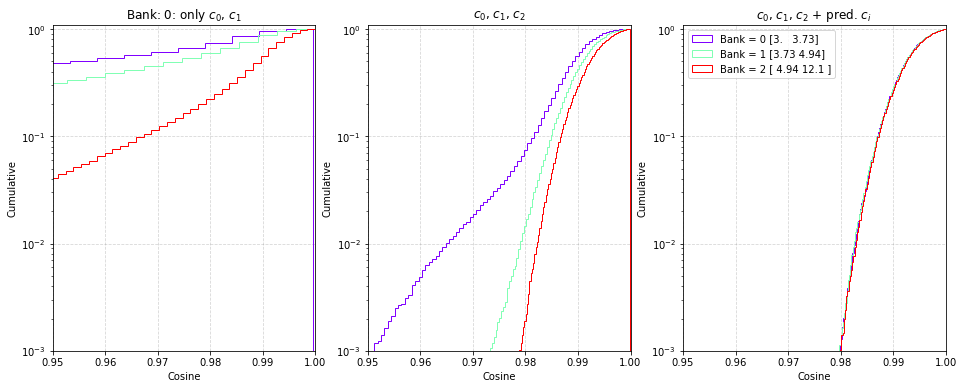

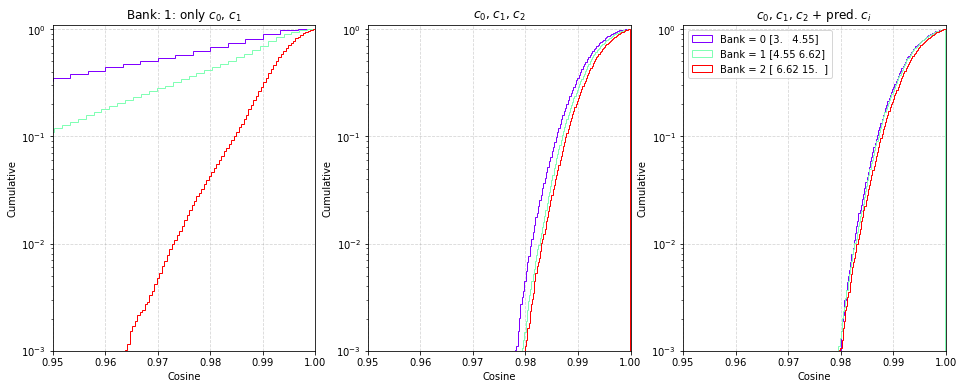

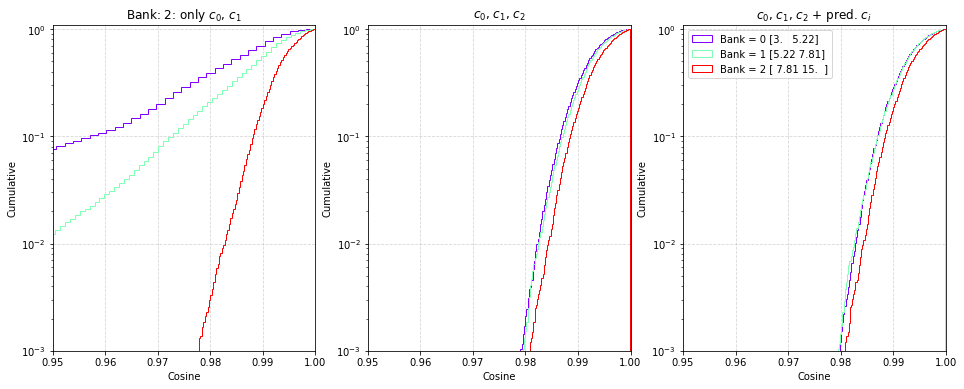

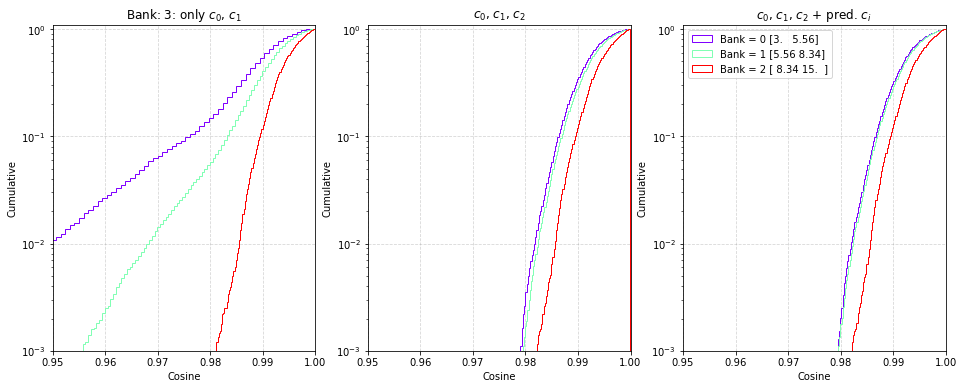

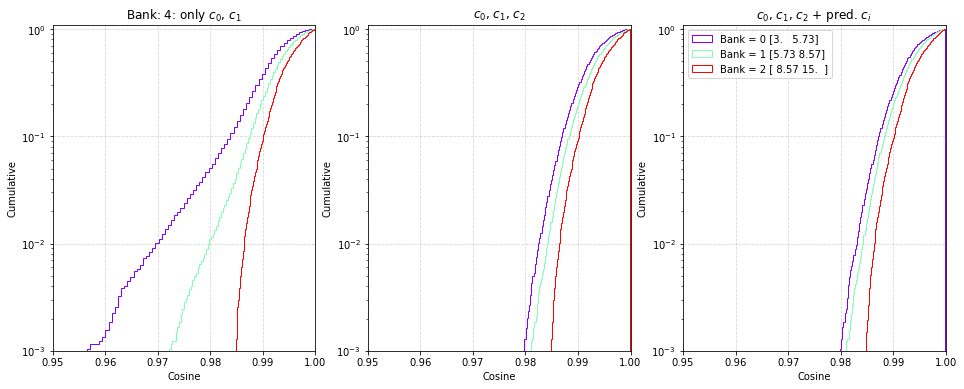

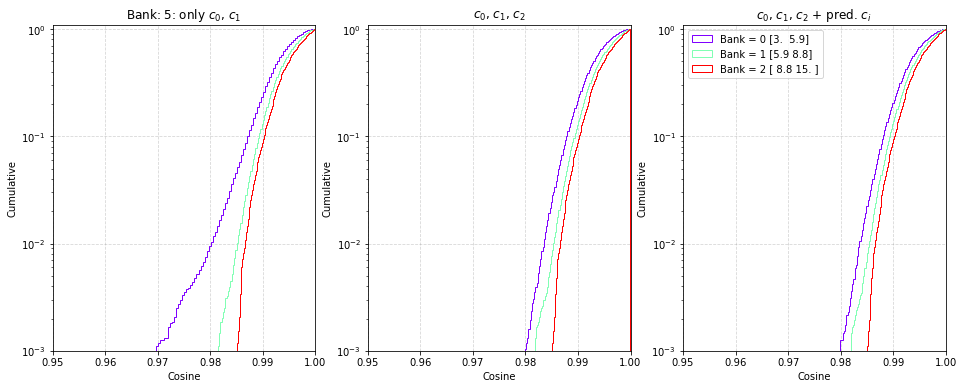

In [36]:
deltac_inv = 4

if not os.path.isdir(os.path.join(DIR, HIGHM_DIR, 'subbank_phase_cosines')):
    os.makedirs(os.path.join(DIR, HIGHM_DIR, 'subbank_phase_cosines'))

for ib in range(nbanks):

    wt=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    SVD_SubBank=SVD_SubBanks[ib]
    cos_exp_f0=[]
    cos_exp_f1=[]
    cos_exp_f2=[]

    for isb in range(len(bins)):
        Up, sp, Vph, mean_phase = SVD_SubBank[isb]
        phases = Up @ np.diag(sp) @ Vph + mean_phase
        ca = Up @ np.diag(sp)

        # Only two basis
        ca2=ca.copy()
        ca2[:,2:]=0
        ca2=np.rint(ca2*deltac_inv)/deltac_inv # Gridding
        phases_f= ca2 @ Vph + mean_phase
        cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))

        # ndims basis
        ca2=ca.copy()
        ca2[:,ndims:]=0
        ca2=np.rint(ca2*deltac_inv)/deltac_inv # Gridding
        phases_f= ca2 @ Vph + mean_phase
        cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))
        
        # ndims basis + regressor
        ca2=ca.copy(); 
        ca2[:,ndims:]=0
        ca2=np.rint(ca2*deltac_inv)/deltac_inv; 

        # Training a RF:
        # ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
        # ca2=ca2[ind]; 
        # phases=phases[ind]
        # rg_rf.fit(ca[:, :ndims][~ind],ca[:,ndims:ndim_final][~ind])

        # or directly loading the RF:
        with open(os.path.join(DIR, HIGHM_DIR,'love_'+str(ib),'bank_'+str(isb),f'RandomForest.pkl'), 'rb') as f:
            rg_rf = pickle.load(f)

        ca2[:,ndims:ndim_final]=rg_rf.predict(ca2[:,:ndims])
        phases_f= ca2 @ Vph + mean_phase
        cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))

    from matplotlib.pyplot import cm
    color = cm.rainbow(np.linspace(0, 1, len(bins)))
    fig = plt.figure(figsize=(16,6))

    plt.subplot(131)
    for isb in range(len(bins)):
        _=plt.hist(cos_exp_f0[isb],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb], decimals=2)),cumulative=True,color=color[isb])

    plt.yscale('log')
    plt.ylim(0.001,1.1); plt.xlim(0.95,1)
    plt.xlabel('Cosine'); plt.ylabel('Cumulative')
    plt.title('Bank: '+str(ib)+': only $c_0$, $c_1$');
    plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)

    plt.subplot(132)
    for isb in range(len(bins)):
        _=plt.hist(cos_exp_f1[isb],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb], decimals=2)),cumulative=True,color=color[isb])

    plt.yscale('log')
    plt.ylim(0.001,1.1); plt.xlim(0.95,1)
    plt.xlabel('Cosine'); plt.ylabel('Cumulative')
    if ndims == 3:
        plt.title('$c_0$, $c_1$, $c_2$');
    elif ndims == 4:
        plt.title('$c_0$, $c_1$, $c_2$, $c_3$');
    else:
        raise Exception('How many ndims?')
    plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)

    plt.subplot(133)
    for isb in range(len(bins)):
        _=plt.hist(cos_exp_f2[isb],bins=100,density=True,histtype='step',label='Bank = '+str(isb)+' '+ str(np.round(bins[isb], decimals=2)),cumulative=True,color=color[isb])

    plt.yscale('log')
    plt.legend(loc=2) #loc=(1.05,0)
    plt.ylim(0.001,1.1); plt.xlim(0.95,1)
    plt.xlabel('Cosine'); plt.ylabel('Cumulative')
    if ndims == 3:
        plt.title('$c_0$, $c_1$, $c_2$ + pred. $c_i$');
    elif ndims == 4:
        plt.title('$c_0$, $c_1$, $c_2$, $c_3$ + pred. $c_i$');
    else:
        raise Exception('How many ndims?')
    plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)

    fig.savefig(os.path.join(DIR, HIGHM_DIR, 'subbank_phase_cosines', f'love_{ib}.pdf'), bbox_inches='tight')

## 3. Test bank effectualness

### 3.1 Generate and load test params

In [8]:
# nwf_test = 100000
# pars_test = generate_params(nwf_test)
# np.save(os.path.join(DIR, HIGHM_DIR, 'pars_samples_test.npy'), pars_test)

In [9]:
# pars_test before masking
pars_test = np.load(os.path.join(DIR, HIGHM_DIR,  'pars_samples_test.npy'))

Mrandom_test, etarandom_test = pars_test[:,0] + pars_test[:,1], (pars_test[:,0]*pars_test[:,1])/(pars_test[:,0] + pars_test[:,1])**2
Mchrandom_test = Mrandom_test * etarandom_test**0.6
leffrandom_test = leff(pars_test[:,0], pars_test[:,1], pars_test[:,2], pars_test[:,3])

In [40]:
# # Generate amplitudes of test samples, and create their bank ids
# # Rerun if we build new banks

# def amps_love(fs, input_par):
#     Mtot = input_par[0]+input_par[1]
#     eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
#     amp, _, fcutoff = lovewf.hf3hPN_TLN(fs, M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)
#     return np.abs(amp)

# def fcutoffs_love(fs, input_par):
#     Mtot = input_par[0]+input_par[1]
#     eta = (input_par[0]*input_par[1])/(input_par[0] + input_par[1])**2
#     _, _, fcutoff = lovewf.hf3hPN_TLN(fs, M=Mtot, eta=eta, Love1=input_par[2], Love2=input_par[3], AmpPhase=True)
#     return fcutoff

# start = time.perf_counter()
# with multiprocess.Pool(10) as p:
#     amps_samples_test = np.abs(p.starmap(amps_love, 
#                                     ((f_amp, input_par) for input_par in pars_test)))
#     fcutoff_samples_test = p.starmap(fcutoffs_love, 
#                                 ((f_amp, input_par) for input_par in pars_test))
# end = time.perf_counter()
# print(f'Duration: {end-start} (s)')

# np.save(os.path.join(DIR, HIGHM_DIR, 'amps_samples_test.npy'), amps_samples_test)
# np.save(os.path.join(DIR, HIGHM_DIR, 'fcutoff_samples_test.npy'), fcutoff_samples_test)

/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning: overflow encountered in exp
  (1.0 - (1.0 / (1.0 + np.exp(-(f - 1.2 * f_cutoff)))))
/home/hschia/data/love/loveNum_waveform_merger.py:331: RuntimeWarning:

Duration: 85.46706429123878 (s)


In [10]:
amps_samples_test = np.load(os.path.join(DIR, HIGHM_DIR, 'amps_samples_test.npy'))
amps_samples_scaled_test = amps_samples_test/Aref
norm_test = np.sum(weights*amps_samples_scaled_test**2,axis=-1)**0.5
amps_samples_norm_test = amps_samples_scaled_test / norm_test[:,None]

with open(os.path.join(DIR, HIGHM_DIR, 'kmeans.pkl'), 'rb') as f:
       kmeans = pickle.load(f)

# Compute Af_kmeans
Af_kmeans = np.asarray([x/np.sum(x**2*weights)**0.5 for x in kmeans.cluster_centers_]) # Weighted with mean amplitude, unlike above which is weighted with each sample amplitude
Af_kmeans_cumsum = np.cumsum(Af_kmeans**2*weights,axis=1)

# Some banks may have slightly different Af_kmeans vs kmeans.cluster_centers_ because the weights are not exactly uniform (see f_amp-weights plot above)
# Only the reference waveform with smallest truncation frequency is affected
[np.allclose(Af_kmeans[i], kmeans.cluster_centers_[i], rtol=1e-2) for i in range(len(Af_kmeans))]

# Create bank ids in ascending order of size of Af_kmeans
order = np.argsort(np.argmin((Af_kmeans_cumsum-0.97)**2,axis=1))[::-1] 
Af_kmeans = Af_kmeans[order]
Af_kmeans_cumsum = Af_kmeans_cumsum[order]

bank_ids_test = kmeans.predict(amps_samples_norm_test)
bank_ids_test = np.asarray([np.where(order == b)[0][0] for b in bank_ids_test]) # step needed because sklearn kmeans location is different from our bank id convention
np.save(os.path.join(DIR, HIGHM_DIR,'bank_ids_test.npy'), bank_ids_test)

fcutoff_samples_test = np.load(os.path.join(DIR, HIGHM_DIR, 'fcutoff_samples_test.npy'))
bank_ids_test = np.load(os.path.join(DIR, HIGHM_DIR,'bank_ids_test.npy')) # rmb to rerun after making new banks everytime

In [11]:
fcutoff_mask_test = fcutoff_samples_test > fmin_cutoff
mass_mask_test = (Mchrandom_test>mch_cutoff)&(Mchrandom_test<mch_cutoff_upper)&(Mrandom_test<M_max)
mask_test = fcutoff_mask_test*mass_mask_test

In [12]:
pars_test = pars_test[mask_test]
amps_samples_test = amps_samples_test[mask_test]
fcutoff_samples_test = fcutoff_samples_test[mask_test]
bank_ids_test = bank_ids_test[mask_test]

Mrandom_test = Mrandom_test[mask_test]
etarandom_test  = etarandom_test[mask_test]
Mchrandom_test = Mchrandom_test[mask_test]
leffrandom_test = leffrandom_test[mask_test]

In [13]:
# Load subbank information
with open(os.path.join(DIR,HIGHM_DIR, 'SubBank_Mchirp_bins.pkl'), 'rb') as f:
    SubBank_Mchirp_bins = pickle.load(f)

In [14]:
SubBank_Mchirp_bins

[[(3.0000015128225694, 3.727498770313096),
  (3.727498770313096, 4.937273693503806),
  (4.937273693503806, 12.098522648848862)],
 [(3.0001526666008718, 4.554203839649236),
  (4.554203839649236, 6.621174376589585),
  (6.621174376589585, 14.996587478262763)],
 [(3.000024266382249, 5.222163238101857),
  (5.222163238101857, 7.807031119605848),
  (7.807031119605848, 14.99924004954862)],
 [(3.000146516478132, 5.561970208168082),
  (5.561970208168082, 8.337172614649528),
  (8.337172614649528, 14.997804238786696)],
 [(3.0004685880214708, 5.732059120243738),
  (5.732059120243738, 8.567864042033968),
  (8.567864042033968, 14.999467214955294)],
 [(3.0003931923863805, 5.899345501213837),
  (5.899345501213837, 8.798284313416078),
  (8.798284313416078, 14.999509953635046)]]

### 3.2 Tweak bank hyperparameters and compute bank effectualness with test samples

In [43]:
ib=1; # Bank number
isb=2; # Sub-bank number
delta_calpha = 0.9
fudge = 1.1

bank = tg.TemplateBank.from_json(os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(round(params.DEF_FFTSIZE), 1/(2*params.FMAX_OVERLAP)) # dt=1/(2*params.FMAX_OVERLAP = 1/2048 is used in search code
coeff_grid = bank.get_coeff_grid(delta_calpha=delta_calpha, fudge=fudge)
print('coeff_grid shape:', coeff_grid.shape)

/home/hschia/data/love/template_bank_generator_love.py:387: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1022: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (188, 10)


In [44]:
fftsize_time = round(params.DEF_FFTSIZE)*1/(2*params.FMAX_OVERLAP)
print(fftsize_time)
if fftsize_time < params.DEF_CHUNKTIME_PSD:
    raise Exception("fftsize in time is below Welch's chunktime psd!")

256.0


In [45]:
# Select waveforms in specific subbank

_ = Mchrandom_test[bank_ids_test==ib]
mask2 = _<SubBank_Mchirp_bins[ib][isb][1]; mask2 *= _>SubBank_Mchirp_bins[ib][isb][0]
pars_test_bank = pars_test[bank_ids_test==ib][mask2]

Mrandom_test_bank = pars_test_bank[:,0] + pars_test_bank[:,1]
etarandom_test_bank = (pars_test_bank[:,0]*pars_test_bank[:,1])/(pars_test_bank[:,0] + pars_test_bank[:,1])**2
Mchrandom_test_bank = Mrandom_test_bank * etarandom_test_bank**0.6
l1random_test_bank, l2random_test_bank = pars_test_bank[:,2], pars_test_bank[:,3]

In [46]:
# plt.scatter(Mchrandom[bank_ids == ib], np.log10(leffrandom[bank_ids == ib]), label=f'{ib}')
# # plt.scatter(Mchrandom_test[bank_ids_test == ib], leffrandom_test[bank_ids_test == ib])
# plt.scatter(Mchrandom[bank_ids == ib-1], np.log10(leffrandom[bank_ids == ib-1]), label=f'{ib-1}', alpha=0.8)
# plt.scatter(Mchrandom[bank_ids == ib+1], np.log10(leffrandom[bank_ids == ib+1]), label=f'{ib+1}', alpha=0.5)

In [47]:
# plt.scatter(Mrandom[bank_ids == ib], np.log10(leffrandom[bank_ids == ib]), label=f'{ib}')
# # plt.scatter(Mchrandom_test[bank_ids_test == ib], leffrandom_test[bank_ids_test == ib])
# plt.scatter(Mrandom[bank_ids == ib-1], np.log10(leffrandom[bank_ids == ib-1]), label=f'{ib-1}')
# plt.scatter(Mrandom[bank_ids == ib+1], np.log10(leffrandom[bank_ids == ib+1]), label=f'{ib+1}')

In [48]:
# Generating log of test wfs

nwfs = 200
fs = bank.fs_unwrap
lwfs = np.zeros((nwfs,len(fs)),dtype='complex128')
#wv_ls = np.where((bank_ids_test==ib))[0][:nwfs]

f_cutoff_test = []
start = time.time()
for ind, i in enumerate(range(0, nwfs)):
    # p = pars_test_bank[i]
    # par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = 0; par_dic['s2z'] = 0;
    # h = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomHM', [(2, 2)])[0]
    # lwfs[i] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))
    hA, hphase, f_cutoff = lovewf.hf3hPN_TLN(fs, M=Mrandom_test_bank[i], eta=etarandom_test_bank[i], Love1=l1random_test_bank[i], Love2=l2random_test_bank[i], AmpPhase=True)
    lwfs[ind] = np.log(hA) + 1j * hphase
    f_cutoff_test.append(f_cutoff)
    
lwfs = tg.upsample_lwfs(lwfs, fs, bank.fs_fft)

time.time()-start

/home/hschia/data/love/template_bank_generator_love.py:161: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


1.4478507041931152

In [49]:
# Making sure zero is recovered

# Generate test waveform
lwfs_0 = bank.gen_wfs_fd_from_calpha(calpha=[[0,0,0]], log=True, fs_out=fs)
lwfs_0up = tg.upsample_lwfs(lwfs_0, fs, bank.fs_fft)

# ind=0
# lwfs_0up = lwfs[None,ind]
# mask_end = np.argmin(bank.fs_basis < f_cutoff_test[ind])

# Project the 22 waveforms into calpha space
phases_22 = tg.upsample_lwfs(
    lwfs_0up, bank.fs_fft, bank.fs_basis, phase_only=True)
coeffs_exact = tg.transform_basis(
    phases_22, bank.avg_phase_evolution, bank.basis, bank.wts,
    bank.fs_basis)

# phases_22 = tg.upsample_lwfs(
#     lwfs_0up, bank.fs_fft, bank.fs_basis[:mask_end], phase_only=True)
# coeffs_exact = tg.transform_basis(
#     phases_22, bank.avg_phase_evolution[:mask_end], bank.basis[:,:mask_end], bank.wts[:mask_end],
#     bank.fs_basis[:mask_end])

effectualness_debug = bank.test_faithfulness(wfs_fd=lwfs_0up, coeff_grid=coeff_grid, fs_in=bank.fs_fft, do_optimization=True, 
                                             delta_calpha=delta_calpha, ret_overlaps_guess=True, truncate=False) # truncate=FALSE!! There is a bug in shift

print('coeffs_exact: ', coeffs_exact, '\neffectualness_debug: ', effectualness_debug)

if (effectualness_debug < 0.95).any():
    raise Exception('Something wrong with effectualness calculation or with bank!')
elif ([0,0,0,0] not in coeff_grid[:,:4]):
    raise Exception('Zero not in calpha_grid?!')

/home/hschia/data/love/template_bank_generator_love.py:161: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[ 5.26021334e-05 -6.46384589e-06 -1.10823544e-05 -1.07040758e-02
   3.96463641e-05  3.68253173e-04  3.52699969e-05  5.25986913e-06
   5.92242440e-05  2.17974898e-05]] 
effectualness_debug:  [[1.         0.99988206 1.00101971]]


In [50]:
# Compute effectualness
start = time.time()
effectualness = bank.test_faithfulness(wfs_fd=lwfs, coeff_grid=coeff_grid, fs_in=bank.fs_fft, do_optimization=True, delta_calpha=delta_calpha, ret_overlaps_guess=True, truncate=False) # truncate=FALSE!! There is a bug in shift
time.time()-start

20.067066431045532

In [51]:
dire = os.path.join(DIR, HIGHM_DIR,'love_'+str(ib))
dire2 = os.path.join(dire, 'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha}.npy')
np.save(dire2, effectualness)

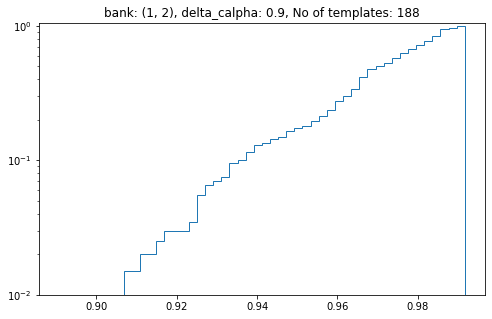

In [52]:
plt.hist(effectualness[:,1], bins=50, histtype='step',cumulative=True, density=True)
plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
plt.yscale('log')
plt.ylim(1e-2, 1.05)
plt.savefig(os.path.join(dire,'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha}.pdf'), bbox_inches='tight')

#### Dump to json files once happy with effectualness cdf

In [416]:
# # Only comment out if we create new bank_summary!
# bank_summary = {}
# with open(os.path.join(DIR, HIGHM_DIR, 'bank_summary.json'), 'w') as f:
#     json.dump(bank_summary, f)

with open(os.path.join(dire, 'bank_'+str(isb), 'metadata.json'), 'r+') as f:
    dic_metadata = json.load(f)
    dic_metadata.update({'delta_calpha': delta_calpha})
    dic_metadata.update({'n_templates': coeff_grid.shape[0]})
    f.seek(0)
    json.dump(dic_metadata, f)

with open(os.path.join(DIR, HIGHM_DIR, 'bank_summary.json'), 'r+') as f:
    bank_summary = json.load(f)
    bank_summary.update({f'({ib}, {isb})': {'delta_calpha': delta_calpha, 'n_templates': coeff_grid.shape[0]}})
    f.seek(0)
    json.dump(bank_summary, f)

In [417]:
bank_summary

{'(0, 0)': {'delta_calpha': 0.9, 'n_templates': 7596},
 '(1, 0)': {'delta_calpha': 0.9, 'n_templates': 4096},
 '(2, 0)': {'delta_calpha': 0.75, 'n_templates': 3988},
 '(3, 0)': {'delta_calpha': 0.75, 'n_templates': 2436},
 '(4, 0)': {'delta_calpha': 0.75, 'n_templates': 1708},
 '(5, 0)': {'delta_calpha': 0.75, 'n_templates': 1518},
 '(0, 1)': {'delta_calpha': 0.75, 'n_templates': 3746},
 '(1, 1)': {'delta_calpha': 0.5, 'n_templates': 3251},
 '(2, 1)': {'delta_calpha': 0.5, 'n_templates': 1360},
 '(3, 1)': {'delta_calpha': 0.5, 'n_templates': 669},
 '(4, 1)': {'delta_calpha': 0.5, 'n_templates': 442},
 '(5, 1)': {'delta_calpha': 0.5, 'n_templates': 327},
 '(0, 2)': {'delta_calpha': 0.5, 'n_templates': 2971},
 '(1, 2)': {'delta_calpha': 0.5, 'n_templates': 658},
 '(2, 2)': {'delta_calpha': 0.5, 'n_templates': 262},
 '(3, 2)': {'delta_calpha': 0.5, 'n_templates': 182},
 '(4, 2)': {'delta_calpha': 0.5, 'n_templates': 158},
 '(5, 2)': {'delta_calpha': 0.5, 'n_templates': 107}}

### 3.3 Compute effectualness for all banks

In [44]:
if os.path.isfile(os.path.join(DIR, HIGHM_DIR, 'bank_summary.json')):
    pass
else:
    bank_summary = {}
    with open(os.path.join(DIR, HIGHM_DIR, 'bank_summary.json'), 'w') as f:
        json.dump(bank_summary, f)

In [45]:
tbp.delta_calpha

{'love_0': [0.9, 0.75, 0.5],
 'love_1': [0.9, 0.5, 0.5],
 'love_2': [0.75, 0.5, 0.5],
 'love_3': [0.75, 0.5, 0.5],
 'love_4': [0.75, 0.5, 0.5],
 'love_5': [0.75, 0.5, 0.5]}

In [46]:
# Tweak subbanks calpha to loop over to
nbanks=6
delta_calpha = [[0.9, 0.9, 0.75, 0.75, 0.75, 0.75], [0.75, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5]*nbanks]
delta_calpha = np.array(delta_calpha).T # Tranpose it to (ib, isb) shape
fudge = 1.05

/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (4160, 10)


/tmp/ipykernel_243416/3401169396.py:40: RuntimeWarning: divide by zero encountered in log
  lwfs[ind] = np.log(hA) + 1j * hphase
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[-1.62204973e-04 -3.51994356e-05 -1.43675999e-04  1.05400809e-01
  -1.41759330e-02  1.99479078e-03 -2.24648644e-03  1.74168109e-04
   1.08845429e-04  2.50813777e-04]] 
effectualness_debug:  [[0.99408146 0.99408146]]
effectualness calculation takes (s): 20.947996616363525
Finished Bank (0, 0)


/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (3422, 10)


/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[-2.06841926e-04 -3.06201828e-05 -4.32528847e-05 -4.66676559e-02
  -2.35050448e-03 -1.44015995e-03 -3.65853721e-04  1.45080939e-04
   2.48108881e-04  3.54773661e-05]] 
effectualness_debug:  [[0.99728516 0.99844407]]
effectualness calculation takes (s): 27.765597581863403
Finished Bank (1, 0)


/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (3529, 10)


/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[ 1.94804357e-04  1.91754165e-05 -4.37970426e-05  3.28719309e-02
   6.39567993e-04 -8.85593406e-04  6.40391913e-05 -3.32459045e-05
   1.64990393e-04 -2.85594461e-05]] 
effectualness_debug:  [[0.99901749 1.00065049]]
effectualness calculation takes (s): 28.7983877658844
Finished Bank (2, 0)


/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (2053, 10)


/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[-1.12503596e-04 -4.09611893e-05 -1.62149837e-04  2.91492429e-02
   6.24754900e-04  6.84360620e-04  6.56884865e-06  2.19914095e-04
  -2.09685901e-04  3.79486693e-05]] 
effectualness_debug:  [[0.99985562 1.00173567]]
effectualness calculation takes (s): 27.102081537246704
Finished Bank (3, 0)


/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (1496, 10)


/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[ 4.50413583e-05  1.00856949e-04 -2.40644651e-04 -3.04464005e-02
  -5.93543817e-04 -7.43270936e-04 -1.17331588e-06 -3.91500323e-05
  -4.42951503e-04 -9.90639895e-05]] 
effectualness_debug:  [[0.9997093  1.00174403]]
effectualness calculation takes (s): 26.853075981140137
Finished Bank (4, 0)


/home/hschia/data/love/template_bank_generator_love.py:504: RuntimeWarning: overflow encountered in exp
  self.amp[:, mode] /= (1 + np.exp(-x * 2))
/home/hschia/data/love/utils_love.py:1025: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.interp(np.log(f_axis), np.log(freq), np.log(asd),


coeff_grid shape: (1230, 10)


/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/home/hschia/data/love/template_bank_generator_love.py:163: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))


coeffs_exact:  [[ 3.40652921e-05  1.55033638e-04 -2.86866296e-04  3.18019567e-02
   4.07108292e-04  7.41246587e-04  2.42027522e-05  1.25679454e-05
   3.01653700e-04 -4.22555136e-04]] 
effectualness_debug:  [[0.99907656 1.00120395]]
effectualness calculation takes (s): 26.00753426551819
Finished Bank (5, 0)


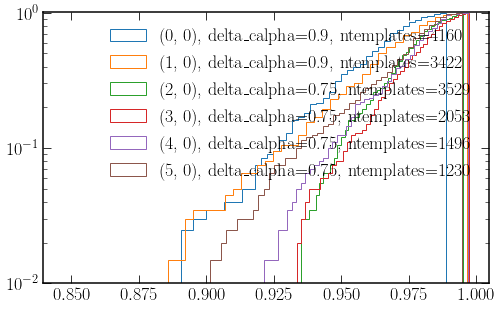

In [51]:
# Generate for loop to speed up generation of bank plots and data
# Reloading the banks, if needed

fig = plt.figure()

isb = 0 # Sub-bank number

for ib in range(0, nbanks):
    bank = tg.TemplateBank.from_json(os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib),'bank_'+str(isb),'metadata.json'))
    # bank = tg.TemplateBank.from_json(os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib),'bank_'+str(isb),'metadata.json'))
    bank.set_waveform_conditioning(params.DEF_FFTSIZE, 1/(2*params.FMAX)) # dt=1/2048
    coeff_grid = bank.get_coeff_grid(delta_calpha=delta_calpha[ib, isb], fudge=fudge)
    print('coeff_grid shape:', coeff_grid.shape)
    
    # Select waveforms in specific subbank

    _ = Mchrandom_test[bank_ids_test==ib]
    mask2 = _<SubBank_Mchirp_bins[ib][isb][1]; mask2 *= _>SubBank_Mchirp_bins[ib][isb][0]
    pars_test_bank = pars_test[bank_ids_test==ib][mask2]

    Mrandom_test_bank = pars_test_bank[:,0] + pars_test_bank[:,1]
    etarandom_test_bank = (pars_test_bank[:,0]*pars_test_bank[:,1])/(pars_test_bank[:,0] + pars_test_bank[:,1])**2
    Mchrandom_test_bank = Mrandom_test_bank * etarandom_test_bank**0.6
    l1random_test_bank, l2random_test_bank = pars_test_bank[:,2], pars_test_bank[:,3]

    # Generating log of test wfs

    nwfs = 200
    fs = bank.fs_unwrap
    lwfs = np.zeros((nwfs,len(fs)),dtype='complex128')
    #wv_ls = np.where((bank_ids_test==ib))[0][:nwfs]

    f_cutoff_test = []
    for ind, i in enumerate(range(0, nwfs)):
        # p = pars_test_bank[i]
        # par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = 0; par_dic['s2z'] = 0;
        # h = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomHM', [(2, 2)])[0]
        # lwfs[i] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))
        hA, hphase, f_cutoff = lovewf.hf3hPN_TLN(fs, M=Mrandom_test_bank[i], eta=etarandom_test_bank[i], Love1=l1random_test_bank[i], Love2=l2random_test_bank[i], AmpPhase=True)
        lwfs[ind] = np.log(hA) + 1j * hphase
        f_cutoff_test.append(f_cutoff)

    lwfs = tg.upsample_lwfs(lwfs, fs, bank.fs_fft)

    # Making sure zero is recovered

    # Generate test waveform
    lwfs_0 = bank.gen_wfs_fd_from_calpha(calpha=[[0,0,0,0]], log=True, fs_out=fs)
    lwfs_0up = tg.upsample_lwfs(lwfs_0, fs, bank.fs_fft)

    # ind=0
    # lwfs_0up = lwfs[None,ind]
    # mask_end = np.argmin(bank.fs_basis < f_cutoff_test[ind])

    # Project the 22 waveforms into calpha space
    phases_22 = tg.upsample_lwfs(
        lwfs_0up, bank.fs_fft, bank.fs_basis, phase_only=True)
    coeffs_exact = tg.transform_basis(
        phases_22, bank.avg_phase_evolution, bank.basis, bank.wts,
        bank.fs_basis)

    # phases_22 = tg.upsample_lwfs(
    #     lwfs_0up, bank.fs_fft, bank.fs_basis[:mask_end], phase_only=True)
    # coeffs_exact = tg.transform_basis(
    #     phases_22, bank.avg_phase_evolution[:mask_end], bank.basis[:,:mask_end], bank.wts[:mask_end],
    #     bank.fs_basis[:mask_end])

    effectualness_debug = bank.test_faithfulness(wfs_fd=lwfs_0up, coeff_grid=coeff_grid, fs_in=bank.fs_fft, do_optimization=True, 
                                                 delta_calpha=delta_calpha[ib, isb], truncate=False)

    print('coeffs_exact: ', coeffs_exact, '\neffectualness_debug: ', effectualness_debug)

    if (effectualness_debug < 0.9).any():
        raise Exception('Something wrong with effectualness calculation or with bank!')
    elif ([0,0,0,0] not in coeff_grid[:,:4]):
        raise Exception('Zero not in calpha_grid?!')

    # Compute effectualness
    start = time.time()
    effectualness = bank.test_faithfulness(wfs_fd=lwfs, coeff_grid=coeff_grid, fs_in=bank.fs_fft, do_optimization=True, delta_calpha=delta_calpha[ib, isb], truncate=False)
    print('effectualness calculation takes (s):', time.time()-start)

    dire = os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib))
    dire2 = os.path.join(dire, 'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha[ib, isb]}.npy')
    np.save(dire2, effectualness)
    
    plt.hist(effectualness[:,1], bins=50, histtype='step',cumulative=True, density=True, label=f'{ib, isb}, delta_calpha={delta_calpha[ib, isb]}, ntemplates={coeff_grid.shape[0]}')
    # plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
    plt.yscale('log')
    plt.savefig(os.path.join(dire,'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha[ib, isb]}.pdf'), bbox_inches='tight')
    plt.ylim([1e-2, 1.02])
    plt.legend()
    
    with open(os.path.join(dire, 'bank_'+str(isb), 'metadata.json'), 'r+') as f:
        dic_metadata = json.load(f)
        dic_metadata.update({'delta_calpha': delta_calpha[ib, isb]})
        dic_metadata.update({'n_templates': coeff_grid.shape[0]})
        f.seek(0)
        json.dump(dic_metadata, f)

        
    # bank_summary_list.append({f'({ib}, {isb})': {'delta_calpha': delta_calpha[ib, isb], 'n_templates': coeff_grid.shape[0]}})            
    with open(os.path.join(DIR, HIGHM_DIR, 'bank_summary.json'), 'r+') as f:
        bank_summary = json.load(f)
        bank_summary.update({f'({ib}, {isb})': {'delta_calpha': delta_calpha[ib, isb], 'n_templates': coeff_grid.shape[0]}})
        f.seek(0)
        json.dump(bank_summary, f)
        
    print(f'Finished Bank {ib,isb}')


In [52]:
bank_summary

{'(0, 1)': {'delta_calpha': 0.75, 'n_templates': 3005},
 '(1, 1)': {'delta_calpha': 0.5, 'n_templates': 2907},
 '(2, 1)': {'delta_calpha': 0.5, 'n_templates': 1190},
 '(3, 1)': {'delta_calpha': 0.5, 'n_templates': 599},
 '(4, 1)': {'delta_calpha': 0.5, 'n_templates': 439},
 '(5, 1)': {'delta_calpha': 0.5, 'n_templates': 277},
 '(0, 2)': {'delta_calpha': 0.5, 'n_templates': 2646},
 '(1, 2)': {'delta_calpha': 0.5, 'n_templates': 578},
 '(2, 2)': {'delta_calpha': 0.5, 'n_templates': 260},
 '(3, 2)': {'delta_calpha': 0.5, 'n_templates': 181},
 '(4, 2)': {'delta_calpha': 0.5, 'n_templates': 133},
 '(5, 2)': {'delta_calpha': 0.5, 'n_templates': 108},
 '(0, 0)': {'delta_calpha': 0.9, 'n_templates': 4160},
 '(1, 0)': {'delta_calpha': 0.9, 'n_templates': 3422},
 '(2, 0)': {'delta_calpha': 0.75, 'n_templates': 3529},
 '(3, 0)': {'delta_calpha': 0.75, 'n_templates': 2053},
 '(4, 0)': {'delta_calpha': 0.75, 'n_templates': 1496},
 '(5, 0)': {'delta_calpha': 0.75, 'n_templates': 1230}}

In [67]:
# fig.savefig(os.path.join(DIR, HIGHM_DIR, f'subbanks{isb}.pdf'), bbox_inches='tight')

In [72]:
# Show num of templates for each subbank
def get_id(string, ind='bank'):
    if ind=='bank':
        return int(string.replace('(', '').replace(')', '').split(', ')[0])
    elif ind=='subbank':
        return int(string.replace('(', '').replace(')', '').split(', ')[1])
        
n_subbank_templates = {}
for i in range(3):
    n_subbank_templates[i] = 0
    for x in list(bank_summary.items()):
        if get_id(x[0], ind='subbank') == i:
            n_subbank_templates[i] += x[1]['n_templates']
        else:
            continue

In [73]:
print('n_subbank_templates: ', n_subbank_templates)
print('n_total_templates: ', sum(list(n_subbank_templates.values())))

n_subbank_templates:  {0: 15890, 1: 8417, 2: 3906}
n_total_templates:  28213


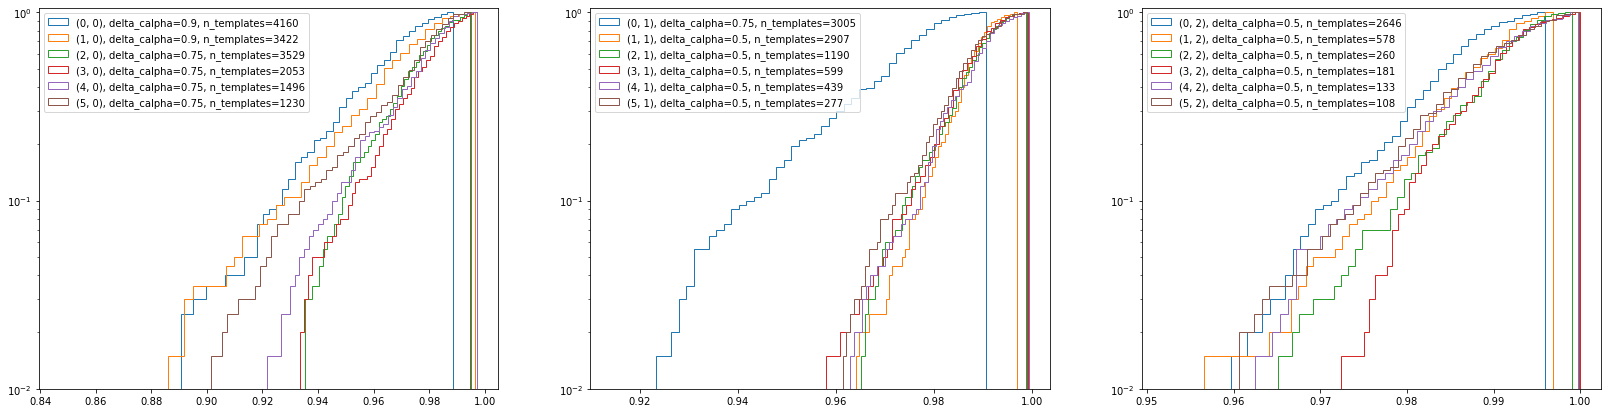

In [74]:
fig, ax = plt.subplots(1,3, figsize=(28,7))

for isb in range(0,3):
    for ib in range(0,nbanks):
        
        dire = os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib))
        with open(os.path.join(dire, 'bank_'+str(isb), 'metadata.json'), 'r') as f:
            dic_metadata_ = json.load(f)
        delta_calpha = dic_metadata_['delta_calpha']
        n_templates = dic_metadata_['n_templates']
        
        dire2 = os.path.join(dire, 'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha}.npy')
        effectualness = np.load(dire2)
        
        # plt.rcParams['figure.figsize'] = (14,8)
        ax[isb].hist(effectualness[:,1], bins=50, histtype='step',cumulative=True, density=True, label=f'{ib, isb}, delta_calpha={delta_calpha}, n_templates={n_templates}')
        # plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
        ax[isb].set_yscale('log')
        ax[isb].set_ylim(1e-2,1.05)
        ax[isb].legend(loc='upper left')

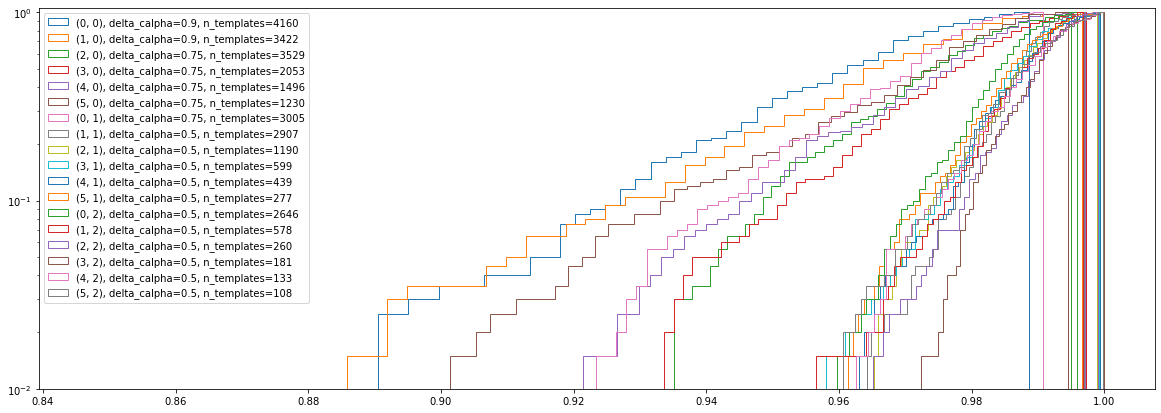

In [76]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

for isb in range(0,3):
    for ib in range(0,nbanks):
        
        dire = os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib))
        with open(os.path.join(dire, 'bank_'+str(isb), 'metadata.json'), 'r') as f:
            dic_metadata_ = json.load(f)
        delta_calpha = dic_metadata_['delta_calpha']
        n_templates = dic_metadata_['n_templates']
        
        dire2 = os.path.join(dire, 'bank_'+str(isb), f'effectualness_delta_calpha_{delta_calpha}.npy')
        effectualness = np.load(dire2)
        
        # plt.rcParams['figure.figsize'] = (14,8)
        ax.hist(effectualness[:,1], bins=50, histtype='step',cumulative=True, density=True, label=f'{ib, isb}, delta_calpha={delta_calpha}, n_templates={n_templates}')
        # plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
        ax.set_yscale('log')
        ax.set_ylim(1e-2,1.05)
        ax.legend(loc='upper left')

### 3.4 Load bank parameters and show final bank effectualness

In [11]:
# Tweak subbanks calpha to loop over to
nbanks=6
delta_calpha = [[0.9, 0.9, 0.75, 0.75, 0.75, 0.75], [0.75, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5]*nbanks]
delta_calpha = np.array(delta_calpha).T # Tranpose it to (ib, isb) shape
fudge = 1.05

In [12]:
effec_bank = {}

Text(0.5, 0, 'Effectualness')

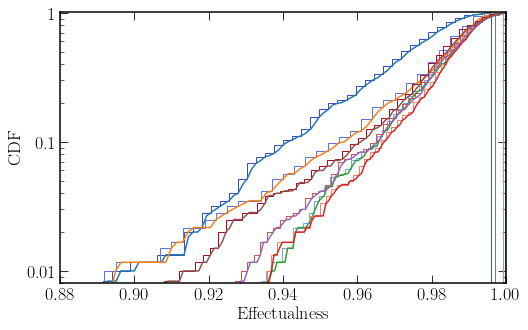

In [34]:
import matplotlib
# color_levels = np.linspace(0.0, 1.0, 6)
color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
# tab10 = list(matplotlib.cm.get_cmap("RdYlBu")(color_levels))
tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# color_levels = np.linspace(0.2, 0.8, 6)
# tab10_iter = iter(matplotlib.cm.get_cmap("cubehelix")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
# cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)

fig = plt.figure()

for ib in range(0, nbanks):
    dire = os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib))
    effec0 = np.load(os.path.join(dire, 'bank_0', f'effectualness_delta_calpha_{delta_calpha[ib, 0]}.npy'))
    effec1 = np.load(os.path.join(dire, 'bank_1', f'effectualness_delta_calpha_{delta_calpha[ib, 1]}.npy'))
    effec2 = np.load(os.path.join(dire, 'bank_2', f'effectualness_delta_calpha_{delta_calpha[ib, 2]}.npy'))
    effec_bank[ib] = np.concatenate([effec0, effec1, effec2])
    
    plt.hist(effec_bank[ib][:,1], bins=50, histtype='step',cumulative=True, density=True, color=next(tab10_iter), label=f'Bank {ib}')
    
    bins=100
    cumsum = np.cumsum(np.histogram(effec_bank[ib][:,1], bins=bins)[0])
    norm = cumsum[-1]
    plt.plot(np.histogram(effec_bank[ib][:,1], bins=bins)[1][1:], np.cumsum(np.histogram(effec_bank[ib][:,1], bins=bins)[0])/norm)
# plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
plt.yscale('log')
plt.ylim([8e-3, 1.02])
plt.xlim([0.88,1.0])
plt.ylabel('CDF')
plt.yticks(ticks=[0.01, 0.1, 1],labels=['0.01', '0.1', '1'])
plt.xlabel('Effectualness')
# plt.legend()

In [60]:
# fig.savefig('love_bank_effectualness.pdf', bbox_inches='tight')

In [ ]:
color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
matplotlib.cm.get_cmap("coolwarm")(color_levels)

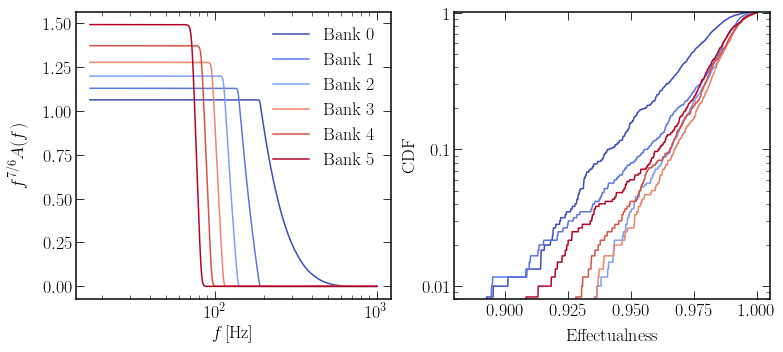

In [49]:
lw=1.5

import matplotlib
# color_levels = np.linspace(0.0, 1.0, 6)
color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
# tab10 = list(matplotlib.cm.get_cmap("RdYlBu")(color_levels))
tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# color_levels = np.linspace(0.2, 0.8, 6)
# tab10_iter = iter(matplotlib.cm.get_cmap("cubehelix")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
# cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)

fig, ax = plt.subplots(1,2,figsize=(11,5))
for i, Af in enumerate(Af_kmeans):
    _ = ax[0].plot(f_amp,Af,'-', c=next(tab10_iter), label=f'Bank {i}', lw=lw)
    
_ = ax[0].set_xlabel('$f$\,[Hz]')
_ = ax[0].set_ylabel(r'$f^{7/6}A(f)$', labelpad=15)
_ = ax[0].set_xscale('log')
_ = ax[0].tick_params(axis='x', pad=5)
_ = ax[0].legend()

# handles_1d, labels_1d = ax.get_legend_handles_labels()
# # handles_1d = swapPositions(handles_1d,2,3)
# # labels_1d = swapPositions(labels_1d,2,3)
# fig.legends = []
# fig.legend(handles_1d, labels_1d, loc='upper left', bbox_to_anchor=(0.13,.88), frameon=False, prop=font)

# ax.set_xlabel('$\chi_{p}$', fontsize=fontsize_label, labelpad=labelpad)
# ax.set_ylabel('Posterior Density Function', fontsize=fontsize_label, labelpad=labelpady)
# plt.setp(ax.get_xticklabels(), size=ticksize)
# plt.setp(ax.get_yticklabels(), size=ticksize)
# fig

import matplotlib
# color_levels = np.linspace(0.0, 1.0, 6)
color_levels = np.array([0.0, 0.1, 0.2, 0.8, 0.9, 1.0])
# tab10 = list(matplotlib.cm.get_cmap("RdYlBu")(color_levels))
tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))
# color_levels = np.linspace(0.2, 0.8, 6)
# tab10_iter = iter(matplotlib.cm.get_cmap("cubehelix")(color_levels))
# tab20b = list(mpl.cm.get_cmap('tab20b').colors)
# cmaplist = tab10 # + tab20b[1::5]  # 24 colors (should be long enough)


for ib in range(0, nbanks):
    dire = os.path.join(DIR, HIGHM_DIR, 'love_'+str(ib))
    effec0 = np.load(os.path.join(dire, 'bank_'+str(0), f'effectualness_delta_calpha_{delta_calpha[ib, 0]}.npy'))
    effec1 = np.load(os.path.join(dire, 'bank_'+str(1), f'effectualness_delta_calpha_{delta_calpha[ib, 1]}.npy'))
    effec2 = np.load(os.path.join(dire, 'bank_'+str(2), f'effectualness_delta_calpha_{delta_calpha[ib, 2]}.npy'))
    effec_bank[ib] = np.concatenate([effec0, effec1, effec2])
    
    bins=1000
    cumsum = np.cumsum(np.histogram(effec_bank[ib][:,1], bins=bins)[0])
    norm = cumsum[-1]
    ax[1].plot(np.histogram(effec_bank[ib][:,1], bins=bins)[1][1:], np.cumsum(np.histogram(effec_bank[ib][:,1], bins=bins)[0])/norm, lw=lw, c=next(tab10_iter))
    
    # ax[1].hist(effec_bank[ib][:,1], bins=50, histtype='step',cumulative=True, lw=lw, density=True, color=next(tab10_iter), label=f'Bank {ib}')
# plt.title(f'bank: {ib, isb}, delta_calpha: {delta_calpha}, No of templates: {coeff_grid.shape[0]}')
ax[1].set_yscale('log')
ax[1].set_ylim([8e-3, 1.02])
ax[1].set_xlim([0.88,1.005])
ax[1].set_ylabel('CDF')
ax[1].set_yticks(ticks=[0.01, 0.1, 1],labels=['0.01', '0.1', '1'])
ax[1].set_xlabel('Effectualness', labelpad=10)
# plt.legend()
fig.tight_layout()

In [50]:
fig.savefig('Aref_effectualness.pdf', bbox_inches='tight')